# 고양시 공공자전거 스테이션 최적 위치 선정

[고양IN夏]: 김성아, 김태경, 남진민. 심현지, 이정원

### - setting

In [130]:
library(data.table)  # 데이터를 UTF-8 형태로 불러올때 사용
library(dplyr)       # 데이터를 전처리할 때 사용
library(ggplot2)     # 정제된 데이터를 시각화할 때 사용
library(lubridate)   # chr 타입을 Date 관련 타입으로 변환할 때 사용
library(stringr)    # 특정기준으로 문자열 추출을 위해 이용
library(gridExtra)   # ggplot 그래프를 동시에 여러개 그릴때 사용
library(repr)        # 그래프 크기 키울때 사용
library(plyr)        # bus 데이터 전처리할때 사용
library(glmnet)   # lasso regression model을 만들 때 필요한 패키지 불러오기
library(showtext) # 그래프 font적용 시 사용

library('leaflet') # 지도 시각화시 사용
library('sp') # 지도 시각화시 사용
library(rgdal) # 지도 시각화시 사용

options("scipen" = 100)     # e 표현을 숫자로 대체하기

font_add_google('Noto Sans KR', 'notosanskr') # 그래프 font적용 시 Noto Sans KR 사용
showtext_auto() # font적용 시 사용
theme_update(text=element_text(family="notosanskr")) # 테마 업데이트, 폰트적용


# 1. 운영이력 data EDA

In [131]:
bicycle = fread("01.운영이력.csv", encoding = "UTF-8")

head(bicycle)   # LEAS_DATE 와 RTN_DATE 가 문자형임을 확인

LEAS_NO,LEAS_STAT,LEAS_DATE,LEAS_STATION,LEAS_DEF_NO,RTN_DATE,RTN_STATION,RTN_DEF_NO,TRNV_QTY,MEMB_DIV,MEMB_NO,TEMP_MEMB_NO,BIKE_TAG,RTN_PROCESS
<int>,<int>,<chr>,<int>,<int>,<chr>,<int>,<int>,<dbl>,<chr>,<int>,<dbl>,<chr>,<dbl>
15945541,2,2017-01-01 00:00:41,213,18,2017-01-01 00:13:52,260,17,0,6,164203,0,1A844000000BB7,NA
15945542,2,2017-01-01 00:01:03,231,4,2017-01-01 00:50:24,231,17,31039,1,187551,0,1A844000000494,NA
15945543,2,2017-01-01 00:01:50,119,14,2017-01-01 01:01:50,0,0,NA,12,168994,0,1A844000000533,1
15945544,2,2017-01-01 00:02:09,121,17,2017-01-01 00:15:58,133,14,15490,12,183971,0,1A844000000731,NA
15945545,2,2017-01-01 00:03:32,320,29,2017-01-01 00:18:44,259,27,0,12,167475,0,1A84400000F343,NA
15945546,2,2017-01-01 00:03:40,309,8,2017-01-01 00:10:50,210,3,0,99,0,3185081,1A84400000F505,NA


In [132]:
dim(bicycle)

[1] 3142688      14

In [133]:
tail(bicycle)

LEAS_NO,LEAS_STAT,LEAS_DATE,LEAS_STATION,LEAS_DEF_NO,RTN_DATE,RTN_STATION,RTN_DEF_NO,TRNV_QTY,MEMB_DIV,MEMB_NO,TEMP_MEMB_NO,BIKE_TAG,RTN_PROCESS
<int>,<int>,<chr>,<int>,<int>,<chr>,<int>,<int>,<dbl>,<chr>,<int>,<dbl>,<chr>,<dbl>
21718607,2,2019-12-31 23:51:54,210,13,2020-01-01 00:23:08,316,1,0,2,235729,0,1A84400000F90F,NA
21718608,2,2019-12-31 23:52:39,222,16,2019-12-31 23:58:56,219,24,0,3,236957,0,1A84400000F881,NA
21718610,2,2019-12-31 23:53:59,343,14,2019-12-31 23:57:59,311,15,0,99,0,4124665,1A84400000F9DA,NA
21718611,2,2019-12-31 23:55:27,333,17,2020-01-01 00:06:24,322,5,0,99,0,4124667,1A84400000048B,NA
21718613,2,2019-12-31 23:59:14,264,4,2020-01-01 00:10:39,210,13,0,12,180671,0,1A84400000F804,NA
21718614,2,2019-12-31 23:59:30,214,18,2020-01-01 00:10:08,222,3,33169,12,215409,0,1A84400000F5C7,NA


### - bicycle data 전처리

In [134]:
sort(c(unique(bicycle$LEAS_STATION )))    # 자전거를 대여한 스테이션들을 중복제거한 후 확인
sort(c(unique(bicycle$RTN_STATION)))      # 자전거를 반납한 스테이션들을 중복제거한 후 확인

[1] 101 103 104 105 106 110 111 112 113 114 115 116 118 119 121 123 124 125
 [19] 126 127 128 129 130 131 133 137 138 139 140 141 142 143 144 146 148 161
 [37] 162 163 164 165 166 167 168 169 170 171 172 173 176 177 178 201 202 203
 [55] 204 205 206 207 210 211 212 213 214 215 216 217 218 219 220 221 222 223
 [73] 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 245
 [91] 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263
[109] 264 265 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316
[127] 317 318 319 320 321 322 323 324 326 327 328 329 330 331 333 334 339 340
[145] 341 342 343 345 346 347 348 349 350 351 992 998

[1]   0 101 103 104 105 106 110 111 112 113 114 115 116 118 119 121 123 124
 [19] 125 126 127 128 129 130 131 133 137 138 139 140 141 142 143 144 146 148
 [37] 161 162 163 164 165 166 167 168 169 170 171 172 173 176 177 178 201 202
 [55] 203 204 205 206 207 210 211 212 213 214 215 216 217 218 219 220 221 222
 [73] 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240
 [91] 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262
[109] 263 264 265 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315
[127] 316 317 318 319 320 321 322 323 324 326 327 328 329 330 331 333 334 339
[145] 340 341 342 343 345 346 347 348 349 350 351 992 998 999

In [135]:
bicycle = bicycle[!bicycle$RTN_STATION %in% c(0,999),] # 자전거를 반납한 스테이션이 0과 999인 것은 제거

In [136]:
bicycle$LEAS_DATE_date = ymd(substr(bicycle$LEAS_DATE,1,10)) #자전거 대여날짜에서 시간제외한 날짜 변수 추가
bicycle$RTN_DATE_date = ymd(substr(bicycle$RTN_DATE,1,10))   #자전거 반납날짜에서 시간제외한 날짜 변수 추가

bicycle$LEAS_DATE_hour = substr(bicycle$LEAS_DATE,12,13)     #자전거 대여날짜에서 대여시간대 변수 추가
bicycle$RTN_DATE_hour = substr(bicycle$RTN_DATE,12,13)      #자전거 반납날짜에서 반납시간대 변수 추가

bicycle$leas_day = weekdays(bicycle$LEAS_DATE_date) # 대여시간에서 요일변수 추가
bicycle$rtn_day = weekdays(bicycle$RTN_DATE_date)   # 반납시간에서 요일변수 추가

bicycle$leas_day_1=ifelse(bicycle$leas_day=="Saturday"|bicycle$leas_day=="Sunday", "주말", "평일") 
bicycle$rtn_day_1=ifelse(bicycle$rtn_day=="Saturday"|bicycle$rtn_day=="Sunday", "주말", "평일") #위의 요일변수를 이용하여 평일,주말 구분

In [137]:
head(bicycle)   # 위의 변수추가 작업이 잘 되었음을 확인

LEAS_NO,LEAS_STAT,LEAS_DATE,LEAS_STATION,LEAS_DEF_NO,RTN_DATE,RTN_STATION,RTN_DEF_NO,TRNV_QTY,MEMB_DIV,⋯,BIKE_TAG,RTN_PROCESS,LEAS_DATE_date,RTN_DATE_date,LEAS_DATE_hour,RTN_DATE_hour,leas_day,rtn_day,leas_day_1,rtn_day_1
<int>,<int>,<chr>,<int>,<int>,<chr>,<int>,<int>,<dbl>,<chr>,⋯,<chr>,<dbl>,<date>,<date>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
15945541,2,2017-01-01 00:00:41,213,18,2017-01-01 00:13:52,260,17,0,6,⋯,1A844000000BB7,NA,2017-01-01,2017-01-01,00,00,Sunday,Sunday,주말,주말
15945542,2,2017-01-01 00:01:03,231,4,2017-01-01 00:50:24,231,17,31039,1,⋯,1A844000000494,NA,2017-01-01,2017-01-01,00,00,Sunday,Sunday,주말,주말
15945544,2,2017-01-01 00:02:09,121,17,2017-01-01 00:15:58,133,14,15490,12,⋯,1A844000000731,NA,2017-01-01,2017-01-01,00,00,Sunday,Sunday,주말,주말
15945545,2,2017-01-01 00:03:32,320,29,2017-01-01 00:18:44,259,27,0,12,⋯,1A84400000F343,NA,2017-01-01,2017-01-01,00,00,Sunday,Sunday,주말,주말
15945546,2,2017-01-01 00:03:40,309,8,2017-01-01 00:10:50,210,3,0,99,⋯,1A84400000F505,NA,2017-01-01,2017-01-01,00,00,Sunday,Sunday,주말,주말
15945547,2,2017-01-01 00:06:42,232,7,2017-01-01 00:15:43,213,18,8948,99,⋯,1A84400000F57C,NA,2017-01-01,2017-01-01,00,00,Sunday,Sunday,주말,주말


### - 시간대별 자전거 스테이션의 대여/반납 이용량 시각화

In [138]:
bicycle_hour_leas_week = bicycle %>% filter(leas_day_1=="평일") %>% 
                         group_by(LEAS_DATE_hour) %>% tally 

bicycle_hour_leas_weekend = bicycle %>% filter(leas_day_1=="주말") %>% 
                         group_by(LEAS_DATE_hour) %>% tally 

bicycle_hour_rtn_week = bicycle %>% filter(rtn_day_1=="평일") %>% 
                         group_by(RTN_DATE_hour) %>% tally

bicycle_hour_rtn_weekend = bicycle %>% filter(rtn_day_1=="주말") %>% 
                         group_by(RTN_DATE_hour) %>% tally

colnames(bicycle_hour_leas_week) = c("hour", "count")
colnames(bicycle_hour_leas_weekend) = c("hour", "count")
colnames(bicycle_hour_rtn_week) = c("hour", "count")
colnames(bicycle_hour_rtn_weekend) = c("hour", "count")

bicycle_hour_leas_week$group = "leas"
bicycle_hour_leas_weekend$group = "leas"
bicycle_hour_rtn_week$group = "rtn"
bicycle_hour_rtn_weekend$group = "rtn"

bicycle_hour_week = rbind(bicycle_hour_leas_week, bicycle_hour_rtn_week)
bicycle_hour_weekend = rbind(bicycle_hour_leas_weekend, bicycle_hour_rtn_weekend)

In [139]:
hour_week = ggplot(bicycle_hour_week, aes(x = hour, y = count, group = group, colour = group))+
    geom_line(size = 1.2)+
    theme_bw()+ theme(axis.text.x = element_text(angle = 30, hjust = 1))+ 
    ylab("평일 자전거 스테이션 이용량") + 
    ggtitle("시간대별 자전거 스테이션 이용량")

hour_weekend = ggplot(bicycle_hour_weekend, aes(x = hour, y = count, group = group, colour = group))+
    geom_line(size = 1.2)+
     theme_bw() + theme(axis.text.x = element_text(angle = 30, hjust = 1))+ 
    ylab("주말 자전거 스테이션 이용량") + 
    ggtitle("시간대별 자전거 스테이션 이용량")



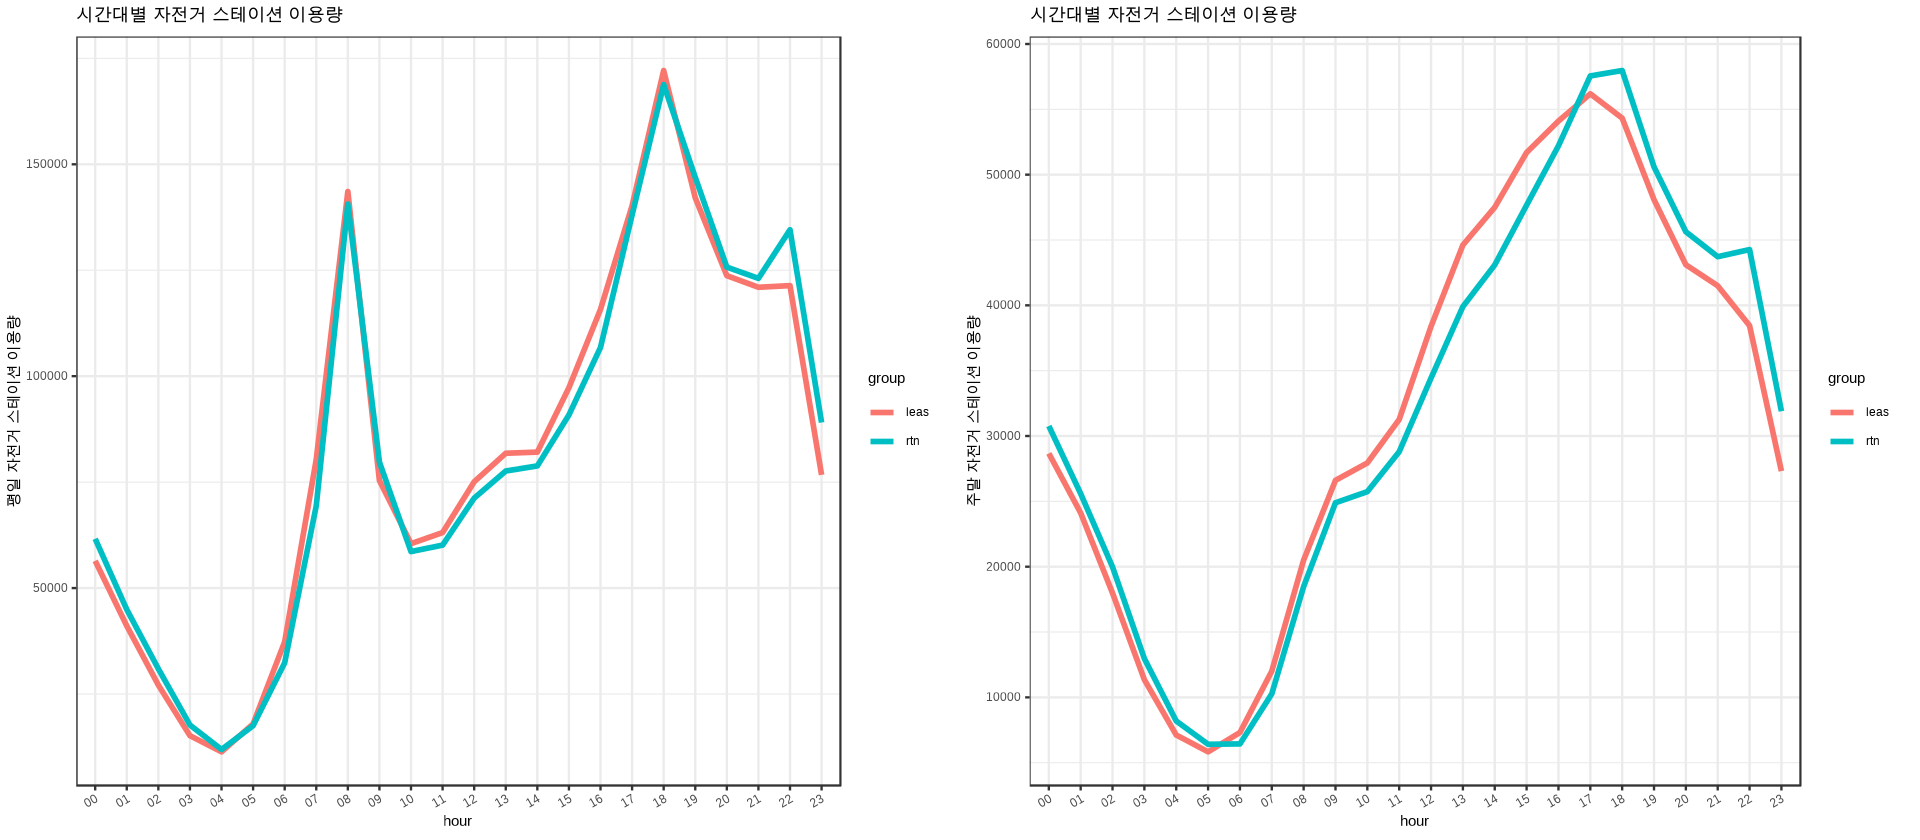

In [140]:
options(repr.plot.width = 16, repr.plot.height = 7)   # 그래프 크기 설정

grid.arrange(hour_week, hour_weekend, ncol = 2)

- 평일 시간대별 자전거 대여,반납 이용량 그래프/ 주말 시간대별 자전거 대여,반납 이용량 그래프
- 평일에는 자전거 대여이용량과 자전거 반납이용량이 비슷한 추이를 보이고 있으며<br> 주말에도 마찬가지로 대여와 반납이 비슷한 추이를 보인다

# 2. 하루 자전거 스테이션 이용량 도출

In [141]:
bicycle$LEAS_STATION = as.character(bicycle$LEAS_STATION)
bicycle$RTN_STATION = as.character(bicycle$RTN_STATION)

head(bicycle)

LEAS_NO,LEAS_STAT,LEAS_DATE,LEAS_STATION,LEAS_DEF_NO,RTN_DATE,RTN_STATION,RTN_DEF_NO,TRNV_QTY,MEMB_DIV,⋯,BIKE_TAG,RTN_PROCESS,LEAS_DATE_date,RTN_DATE_date,LEAS_DATE_hour,RTN_DATE_hour,leas_day,rtn_day,leas_day_1,rtn_day_1
<int>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<dbl>,<chr>,⋯,<chr>,<dbl>,<date>,<date>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
15945541,2,2017-01-01 00:00:41,213,18,2017-01-01 00:13:52,260,17,0,6,⋯,1A844000000BB7,NA,2017-01-01,2017-01-01,00,00,Sunday,Sunday,주말,주말
15945542,2,2017-01-01 00:01:03,231,4,2017-01-01 00:50:24,231,17,31039,1,⋯,1A844000000494,NA,2017-01-01,2017-01-01,00,00,Sunday,Sunday,주말,주말
15945544,2,2017-01-01 00:02:09,121,17,2017-01-01 00:15:58,133,14,15490,12,⋯,1A844000000731,NA,2017-01-01,2017-01-01,00,00,Sunday,Sunday,주말,주말
15945545,2,2017-01-01 00:03:32,320,29,2017-01-01 00:18:44,259,27,0,12,⋯,1A84400000F343,NA,2017-01-01,2017-01-01,00,00,Sunday,Sunday,주말,주말
15945546,2,2017-01-01 00:03:40,309,8,2017-01-01 00:10:50,210,3,0,99,⋯,1A84400000F505,NA,2017-01-01,2017-01-01,00,00,Sunday,Sunday,주말,주말
15945547,2,2017-01-01 00:06:42,232,7,2017-01-01 00:15:43,213,18,8948,99,⋯,1A84400000F57C,NA,2017-01-01,2017-01-01,00,00,Sunday,Sunday,주말,주말


In [142]:
# 자전거 대여를 이용하여 평일,주말,하루 자전거 대여량 구하기

bicycle_1 = bicycle %>% 
  select(LEAS_STATION,leas_day_1) %>% 
  group_by(LEAS_STATION) %>% 
  dplyr::summarise(mean_week_leas = (sum(leas_day_1=="평일")/5)/156.4, mean_weekend_leas=(sum(leas_day_1=="주말")/5)/156.5) %>%
  mutate(mean_day_leas = (mean_week_leas*5+mean_weekend_leas*2)/7 )

bicycle_1 = as.data.frame(bicycle_1)

# 자전거 반납을 이용하여 평일,주말,하루 자전거 대여량 구하기
bicycle_2 = bicycle %>% 
  select(RTN_STATION,rtn_day_1) %>% 
  group_by(RTN_STATION) %>% 
  dplyr::summarise(mean_week_rtn = (sum(rtn_day_1=="평일")/5)/156.4,mean_weekend_rtn=(sum(rtn_day_1=="주말")/5)/156.5) %>%
  mutate(mean_day_rtn = (mean_week_rtn*5+mean_weekend_rtn*2)/7 )

bicycle_2 = as.data.frame(bicycle_2)

head(bicycle_1); head(bicycle_2)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



,LEAS_STATION,mean_week_leas,mean_weekend_leas,mean_day_leas
,<chr>,<dbl>,<dbl>,<dbl>
1,101,6.680307,2.5904153,5.511766
2,103,3.198210,1.5872204,2.737927
3,104,11.084399,3.6920128,8.972289
4,105,2.025575,0.7961661,1.674316
5,106,3.586957,1.1271565,2.884157
6,110,11.919437,3.9718850,9.648708


,RTN_STATION,mean_week_rtn,mean_weekend_rtn,mean_day_rtn
,<chr>,<dbl>,<dbl>,<dbl>
1,101,8.631714,3.1399361,7.062634
2,103,4.459079,2.0881789,3.781679
3,104,8.921995,3.0070288,7.232005
4,105,2.459079,0.9878594,2.038731
5,106,2.287724,0.7258786,1.841482
6,110,13.547315,4.5329073,10.971770


In [143]:
colnames(bicycle_1)[1] = "station"
colnames(bicycle_2)[1] = "station"

bicycle_use = inner_join(bicycle_1,bicycle_2,by='station')   # 위에서 구한 대여이용량과 반납이용량을 join하여 합치기

In [144]:
head(bicycle_use)  # 잘 합쳐진 것을 확인

,station,mean_week_leas,mean_weekend_leas,mean_day_leas,mean_week_rtn,mean_weekend_rtn,mean_day_rtn
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,101,6.680307,2.5904153,5.511766,8.631714,3.1399361,7.062634
2,103,3.198210,1.5872204,2.737927,4.459079,2.0881789,3.781679
3,104,11.084399,3.6920128,8.972289,8.921995,3.0070288,7.232005
4,105,2.025575,0.7961661,1.674316,2.459079,0.9878594,2.038731
5,106,3.586957,1.1271565,2.884157,2.287724,0.7258786,1.841482
6,110,11.919437,3.9718850,9.648708,13.547315,4.5329073,10.971770


- mean_week_leas : 평일 자전거 대여 평균량 / mean_weekend_leas : 주말 자전거 대여 평균량 / mean_day_leas : 하루 자전거 대여 평균량
- mean_week_rtn : 평일 자전거 반납 평균량 / mean_weekend_rtn : 주말 자전거 반납 평균량 / mean_day_rtn : 하루 자전거 반납 평균량

### - 요일별 자전거 대여 / 반납 이용량 시각화

In [145]:
bicy_day_leas = bicycle %>% select(leas_day,LEAS_STATION) %>%  group_by(leas_day)  %>%  tally  

day_leas = ggplot(bicy_day_leas, aes(x= leas_day, y = n, fill = leas_day))+
                  geom_col(position = "dodge", colour = "black")+
                  geom_hline(yintercept = mean(bicy_day_leas$n), linetype = "dashed", color = "red", size = 1)+theme_bw()+
                  scale_x_discrete(limits=c("Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"))+
                  theme(axis.text.x = element_text(angle = 30, hjust = 1))+ 
                  xlab("요일")+ ylab("자전거 대여 이용량") + ggtitle("요일별 자전거 대여 이용량")


bicy_day_rtn = bicycle %>% select(rtn_day,RTN_STATION) %>%  group_by(rtn_day)  %>%  tally  

day_rtn = ggplot(bicy_day_rtn, aes(x= rtn_day, y = n, fill = rtn_day))+
                  geom_col(position = "dodge", colour = "black")+
                  geom_hline(yintercept = mean(bicy_day_rtn$n), linetype = "dashed", color = "red", size = 1)+theme_bw()+
                  scale_x_discrete(limits=c("Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"))+
                  theme(axis.text.x = element_text(angle = 30, hjust = 1))+ 
                  xlab("요일")+ ylab("자전거 반납 이용량") + ggtitle("요일별 자전거 반납 이용량")

In [146]:
bicy_day_leas ; bicy_day_rtn

leas_day,n
<chr>,<int>
Friday,411335
Monday,384384
Saturday,401473
Sunday,364493
Thursday,394306
Tuesday,392813
Wednesday,395640


rtn_day,n
<chr>,<int>
Friday,410378
Monday,383974
Saturday,401455
Sunday,366009
Thursday,394092
Tuesday,392980
Wednesday,395556


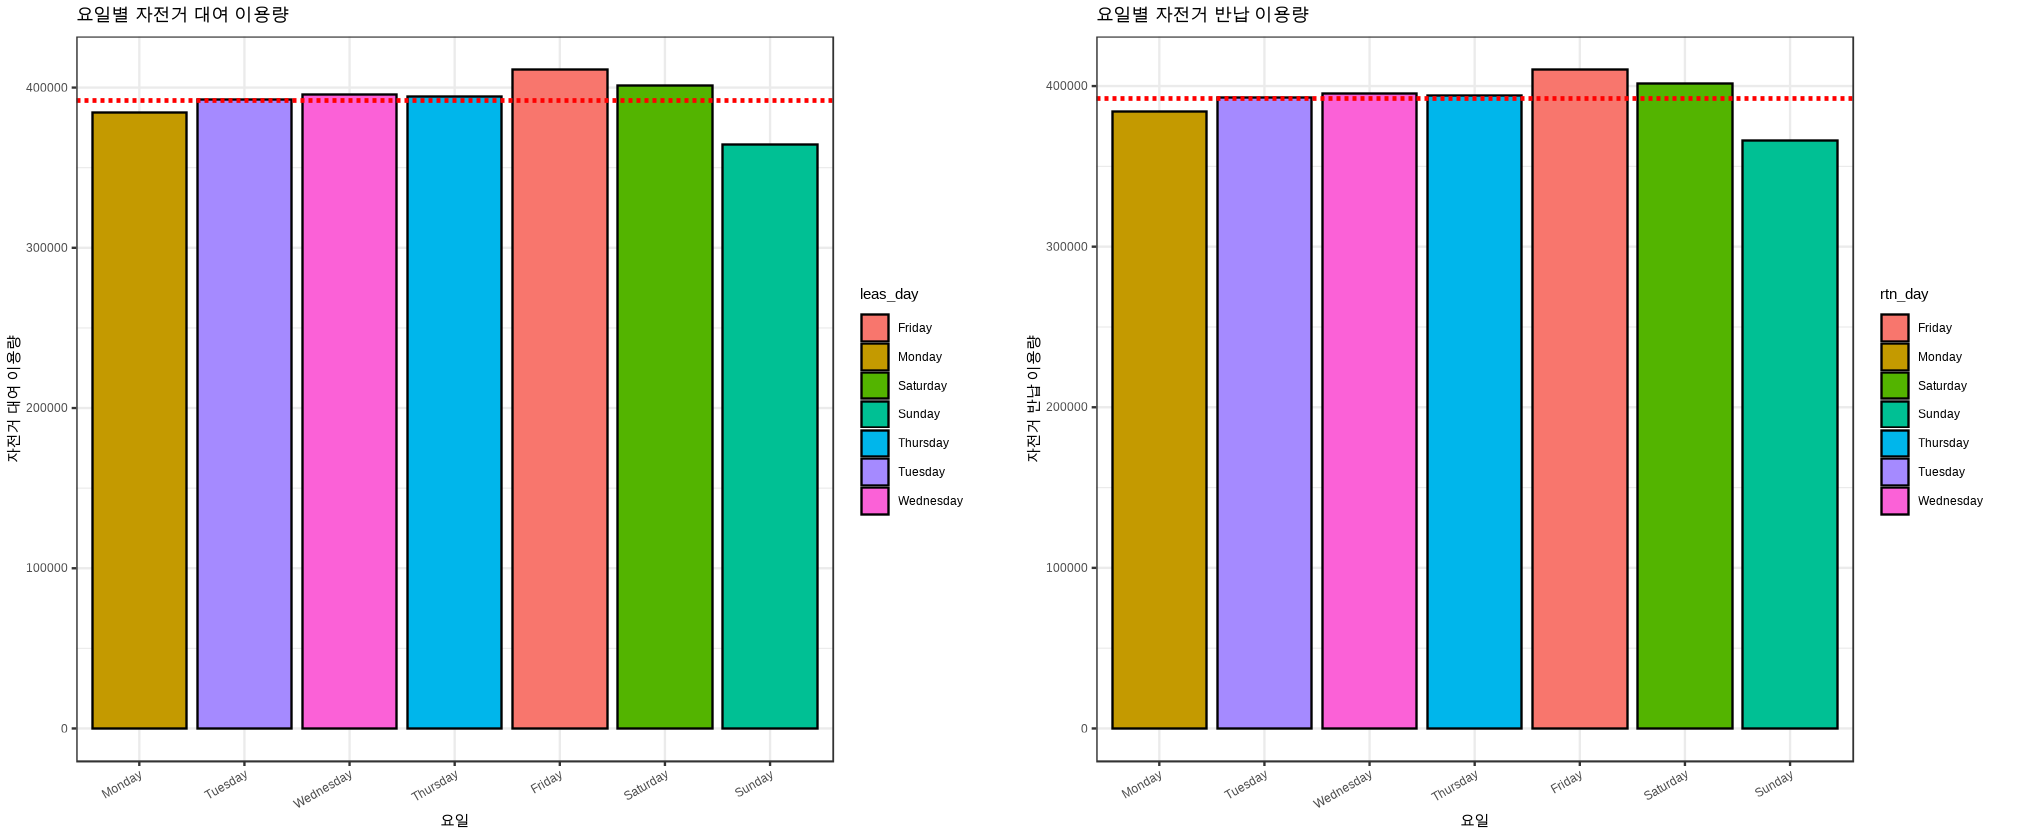

In [147]:
options(repr.plot.width = 17, repr.plot.height = 7)   # 그래프 크기 설정

grid.arrange(day_leas, day_rtn, ncol = 2)

### =>  자전거 대여 이용량과 자전거 반납 이용량이 요일별로 크게 차이가 나지 않으므로<br>        우리는 이 중에서 하루 자전거 대여 평균량(mean_day_leas) 과 하루 자전거 반납 평균량(mean_day_rtn) 만을<br>        이용하여 분석하기로 했다.

### - 자전거 사용량이 많은 자전거 스테이션 TOP20(하루 기준)

- 요일별 자전거 대여 / 반납 이용량 그래프
- 빨간색 선 : 자전거 대여 / 반납 평균값
- 자전거 대여와 반납 이용량 둘다 요일별로 비슷한 수치를 보이고 있지만<br>일요일에는 자전거 대여와 반납 이용량이 다른 요일에 비해 조금 낮은 것을 확인할 수 있다.

In [148]:
bicycle_use$station = as.character(bicycle_use$station)

In [149]:
# theme_update(text=element_text(family="notosanskr"))
# 평일 자전거 대여량이 많은 자전거 정류장 TOP20
bicycle_day_leas1 = bicycle_use %>% select(station, mean_week_leas)

p1 = bicycle_day_leas1[c(order(-bicycle_day_leas1$mean_week_leas)),] %>% head(20) %>% 
                  ggplot(aes(x= station, y = mean_week_leas, fill = station))+
                  geom_col(position = "dodge", colour = "black")+
                  geom_hline(yintercept = mean(bicycle_use$mean_week_leas), linetype = "dashed",
                             color = "red", size = 1)+ theme_bw()+
                  theme(axis.text.x = element_text(angle = 30, hjust = 1))+ 
                  ylab("자전거 대여이용량") + ggtitle("평일 자전거 대여이용량 TOP20") 


# 주말 자전거 대여량이 많은 자전거 정류장 TOP20
bicycle_day_leas2 = bicycle_use %>% select(station, mean_weekend_leas)

p2 = bicycle_day_leas2[c(order(-bicycle_day_leas2$mean_weekend_leas)),] %>% head(20) %>% 
                  ggplot(aes(x= station, y = mean_weekend_leas, fill = station))+
                  geom_col(position = "dodge", colour = "black")+
                  geom_hline(yintercept = mean(bicycle_use$mean_weekend_leas), linetype = "dashed",
                             color = "red", size = 1)+ theme_bw()+
                  theme(axis.text.x = element_text(angle = 30, hjust = 1))+ 
                  ylab("자전거 대여이용량") + ggtitle("주말 자전거 대여이용량 TOP20")


# 하루 자전거 대여량이 많은 자전거 정류장 TOP20
bicycle_day_leas3 = bicycle_use %>% select(station, mean_day_leas)

p3 = bicycle_day_leas3[c(order(-bicycle_day_leas3$mean_day_leas)),] %>% head(20) %>% 
                  ggplot(aes(x= station, y = mean_day_leas, fill = station))+
                  geom_col(position = "dodge", colour = "black")+
                  geom_hline(yintercept = mean(bicycle_use$mean_day_leas), linetype = "dashed",
                             color = "red", size = 1)+ theme_bw()+
                  theme(axis.text.x = element_text(angle = 30, hjust = 1))+ 
                  ylab("자전거 대여이용량") + ggtitle("하루 자전거 대여이용량 TOP20")


# 평일 자전거 반납량이 많은 자전거 정류장 TOP20
bicycle_day_rtn1 = bicycle_use %>% select(station, mean_week_rtn)

p4 = bicycle_day_rtn1[c(order(-bicycle_day_rtn1$mean_week_rtn)),] %>% head(20) %>% 
                  ggplot(aes(x= station, y = mean_week_rtn, fill = station))+
                  geom_col(position = "dodge", colour = "black")+
                  geom_hline(yintercept = mean(bicycle_use$mean_week_rtn), linetype = "dashed",
                             color = "red", size = 1)+ theme_bw()+
                  theme(axis.text.x = element_text(angle = 30, hjust = 1))+ 
                  ylab("자전거 반납이용량") + ggtitle("평일 자전거 반납이용량 TOP20")


# 주말 자전거 반납량이 많은 자전거 정류장 TOP20
bicycle_day_rtn2 = bicycle_use %>% select(station, mean_weekend_rtn)

p5 = bicycle_day_rtn2[c(order(-bicycle_day_rtn2$mean_weekend_rtn)),] %>% head(20) %>% 
                  ggplot(aes(x= station, y = mean_weekend_rtn, fill = station))+
                  geom_col(position = "dodge", colour = "black")+
                  geom_hline(yintercept = mean(bicycle_use$mean_weekend_rtn), linetype = "dashed",
                             color = "red", size = 1)+ theme_bw()+
                  theme(axis.text.x = element_text(angle = 30, hjust = 1))+ 
                  ylab("자전거 반납이용량") + ggtitle("주말 자전거 반납이용량 TOP20")

# 하루 자전거 반납량이 많은 자전거 정류장 TOP20
bicycle_day_rtn3 = bicycle_use %>% select(station, mean_day_rtn)

p6 = bicycle_day_rtn3[c(order(-bicycle_day_rtn3$mean_day_rtn)),] %>% head(20) %>% 
                  ggplot(aes(x= station, y = mean_day_rtn, fill = station))+
                  geom_col(position = "dodge", colour = "black")+
                  geom_hline(yintercept = mean(bicycle_use$mean_day_rtn), linetype = "dashed",
                             color = "red", size = 1)+ theme_bw()+
                  theme(axis.text.x = element_text(angle = 30, hjust = 1))+ 
                  ylab("자전거 반납이용량") + ggtitle("하루 자전거 반납이용량 TOP20")

### - 자전거 사용량이 많은 자전거 스테이션 TOP20(주별 기준)

In [150]:
# 자전거 대여를 이용하여 평일만 고려된 주,주말만 고려된 주,주별 자전거 대여량 구하기

bicycle_week1 = bicycle %>% 
  select(LEAS_STATION,leas_day_1) %>% 
  group_by(LEAS_STATION) %>% 
  dplyr::summarise(mean_week_leas = (sum(leas_day_1=="평일")/5), mean_weekend_leas=(sum(leas_day_1=="주말")/5)) %>%
  mutate(mean_day_leas = (mean_week_leas*5+mean_weekend_leas*2)/7 )

bicycle_week1 = as.data.frame(bicycle_week1)
bicycle_week1 = na.omit(bicycle_week1)

# 자전거 반납을 이용하여 평일만 고려된 주,주말만 고려된 주,주별 자전거 반납량 구하기
bicycle_week2 = bicycle %>% 
  select(RTN_STATION,rtn_day_1) %>% 
  group_by(RTN_STATION) %>% 
  dplyr::summarise(mean_week_rtn = (sum(rtn_day_1=="평일")/5),mean_weekend_rtn=(sum(rtn_day_1=="주말")/5)) %>%
  mutate(mean_day_rtn = (mean_week_rtn*5+mean_weekend_rtn*2)/7 )

bicycle_week2 = as.data.frame(bicycle_week2)
bicycle_week2 = na.omit(bicycle_week2)


head(bicycle_week1); head(bicycle_week2)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



,LEAS_STATION,mean_week_leas,mean_weekend_leas,mean_day_leas
,<chr>,<dbl>,<dbl>,<dbl>
1,101,1044.8,405.4,862.1143
2,103,500.2,248.4,428.2571
3,104,1733.6,577.8,1403.3714
4,105,316.8,124.6,261.8857
5,106,561.0,176.4,451.1143
6,110,1864.2,621.6,1509.1714


,RTN_STATION,mean_week_rtn,mean_weekend_rtn,mean_day_rtn
,<chr>,<dbl>,<dbl>,<dbl>
1,101,1350.0,491.4,1104.6857
2,103,697.4,326.8,591.5143
3,104,1395.4,470.6,1131.1714
4,105,384.6,154.6,318.8857
5,106,357.8,113.6,288.0286
6,110,2118.8,709.4,1716.1143


In [151]:
colnames(bicycle_week1)[1] = "station"
colnames(bicycle_week2)[1] = "station"

bicycle_week_use = inner_join(bicycle_week1,bicycle_week2,by='station')   # 위에서 구한 대여이용량과 반납이용량을 join하여 합치기

In [152]:
head(bicycle_week_use)

,station,mean_week_leas,mean_weekend_leas,mean_day_leas,mean_week_rtn,mean_weekend_rtn,mean_day_rtn
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,101,1044.8,405.4,862.1143,1350.0,491.4,1104.6857
2,103,500.2,248.4,428.2571,697.4,326.8,591.5143
3,104,1733.6,577.8,1403.3714,1395.4,470.6,1131.1714
4,105,316.8,124.6,261.8857,384.6,154.6,318.8857
5,106,561.0,176.4,451.1143,357.8,113.6,288.0286
6,110,1864.2,621.6,1509.1714,2118.8,709.4,1716.1143


In [153]:
# theme_update(text=element_text(family="notosanskr"))
# 평일기준 한 주에 자전거 대여량이 많은 자전거 정류장 TOP20
bicycle_week_leas = bicycle_week_use %>% select(station, mean_week_leas)

q1 = bicycle_week_leas[c(order(-bicycle_week_leas$mean_week_leas)),] %>% head(20) %>% 
                  ggplot(aes(x= station, y = mean_week_leas, fill = station))+
                  geom_col(position = "dodge", colour = "black")+
                  geom_hline(yintercept = mean(bicycle_week_use$mean_week_leas), linetype = "dashed",
                             color = "red", size = 1)+ theme_bw()+
                  theme(axis.text.x = element_text(angle = 30, hjust = 1))+ 
                  ylab("자전거 대여이용량") + ggtitle("평일 기준 한 주 자전거 대여이용량 TOP20") 


# 주말기준 한 주에 자전거 대여량이 많은 자전거 정류장 TOP20
bicycle_weekend_leas = bicycle_week_use %>% select(station, mean_weekend_leas)

q2 = bicycle_weekend_leas[c(order(-bicycle_weekend_leas$mean_weekend_leas)),] %>% head(20) %>% 
                  ggplot(aes(x= station, y = mean_weekend_leas, fill = station))+
                  geom_col(position = "dodge", colour = "black")+
                  geom_hline(yintercept = mean(bicycle_week_use$mean_weekend_leas), linetype = "dashed",
                             color = "red", size = 1)+ theme_bw()+
                  theme(axis.text.x = element_text(angle = 30, hjust = 1))+ 
                  ylab("자전거 대여이용량") + ggtitle("주말 기준 한 주 자전거 대여이용량 TOP20")
 

# 하루기준 한 주에 자전거 대여량이 많은 자전거 정류장 TOP20
bicycle_week_d_leas = bicycle_week_use %>% select(station, mean_day_leas)

q3 = bicycle_week_d_leas[c(order(-bicycle_week_d_leas$mean_day_leas)),] %>% head(20) %>% 
                  ggplot(aes(x= station, y = mean_day_leas, fill = station))+
                  geom_col(position = "dodge", colour = "black")+
                  geom_hline(yintercept = mean(bicycle_week_use$mean_day_leas), linetype = "dashed",
                             color = "red", size = 1)+ theme_bw()+
                  theme(axis.text.x = element_text(angle = 30, hjust = 1))+ 
                  ylab("자전거 대여이용량") + ggtitle("하루 기준 한 주 자전거 대여이용량 TOP20")


# 평일기준 한 주에 자전거 반납량이 많은 자전거 정류장 TOP20
bicycle_week_rtn = bicycle_week_use %>% select(station, mean_week_rtn)

q4 = bicycle_week_rtn[c(order(-bicycle_week_rtn$mean_week_rtn)),] %>% head(20) %>% 
                  ggplot(aes(x= station, y = mean_week_rtn, fill = station))+
                  geom_col(position = "dodge", colour = "black")+
                  geom_hline(yintercept = mean(bicycle_week_use$mean_week_rtn), linetype = "dashed",
                             color = "red", size = 1)+ theme_bw()+
                  theme(axis.text.x = element_text(angle = 30, hjust = 1))+ 
                  ylab("자전거 반납이용량") + ggtitle("평일 기준 한 주 자전거 반납이용량 TOP20")


# 주말기준 한 주에 자전거 반납량이 많은 자전거 정류장 TOP20
bicycle_weekend_rtn = bicycle_week_use %>% select(station, mean_weekend_rtn)

q5 = bicycle_weekend_rtn[c(order(-bicycle_weekend_rtn$mean_weekend_rtn)),] %>% head(20) %>% 
                  ggplot(aes(x= station, y = mean_weekend_rtn, fill = station))+
                  geom_col(position = "dodge", colour = "black")+
                  geom_hline(yintercept = mean(bicycle_week_use$mean_weekend_rtn), linetype = "dashed",
                             color = "red", size = 1)+ theme_bw()+
                  theme(axis.text.x = element_text(angle = 30, hjust = 1))+ 
                  ylab("자전거 반납이용량") + ggtitle("주말 자전거 반납이용량 TOP20")

# 하루기준 한 주에 자전거 반납량이 많은 자전거 정류장 TOP20
bicycle_week_d_rtn = bicycle_week_use %>% select(station, mean_day_rtn)

q6 = bicycle_week_d_rtn[c(order(-bicycle_week_d_rtn$mean_day_rtn)),] %>% head(20) %>% 
                  ggplot(aes(x= station, y = mean_day_rtn, fill = station))+
                  geom_col(position = "dodge", colour = "black")+
                  geom_hline(yintercept = mean(bicycle_week_use$mean_day_rtn), linetype = "dashed",
                             color = "red", size = 1)+ theme_bw()+
                  theme(axis.text.x = element_text(angle = 30, hjust = 1))+ 
                  ylab("자전거 반납이용량") + ggtitle("하루 자전거 반납이용량 TOP20")

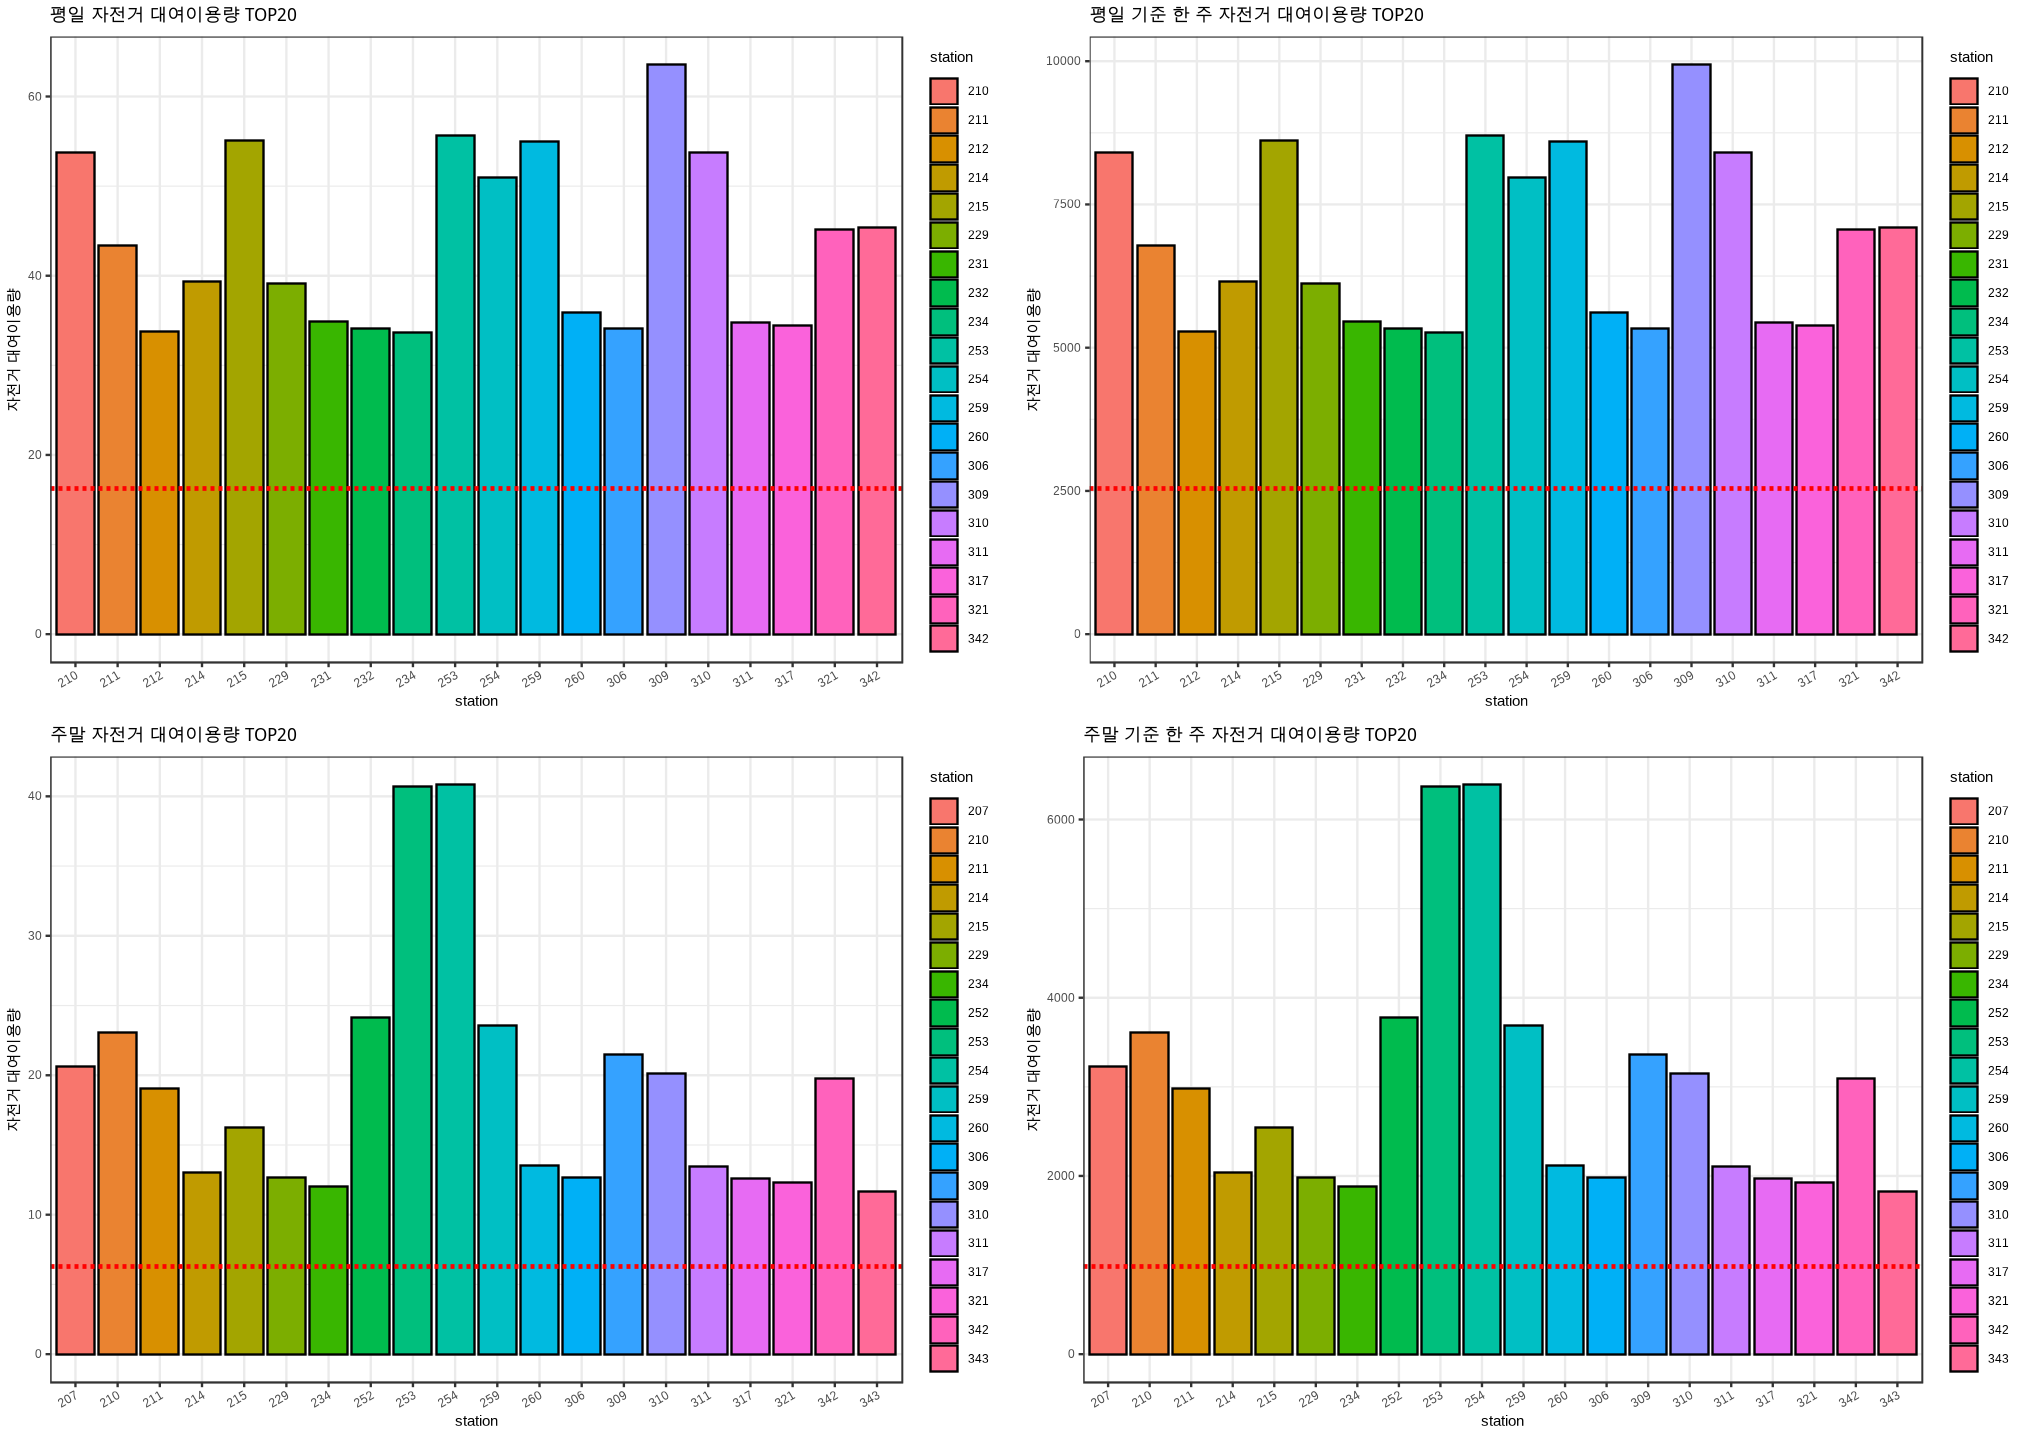

In [154]:
options(repr.plot.width = 17, repr.plot.height = 12)   # 그래프 크기 설정

grid.arrange(p1,q1,p2,q2, ncol=2)

- 하루 기준 평일과 주말 자전거 대여 이용량과 한 주 기준 평일과 주말 자전거 대여 이용량을 비교했을때<br>   TOP20 순위는 비슷하다. 

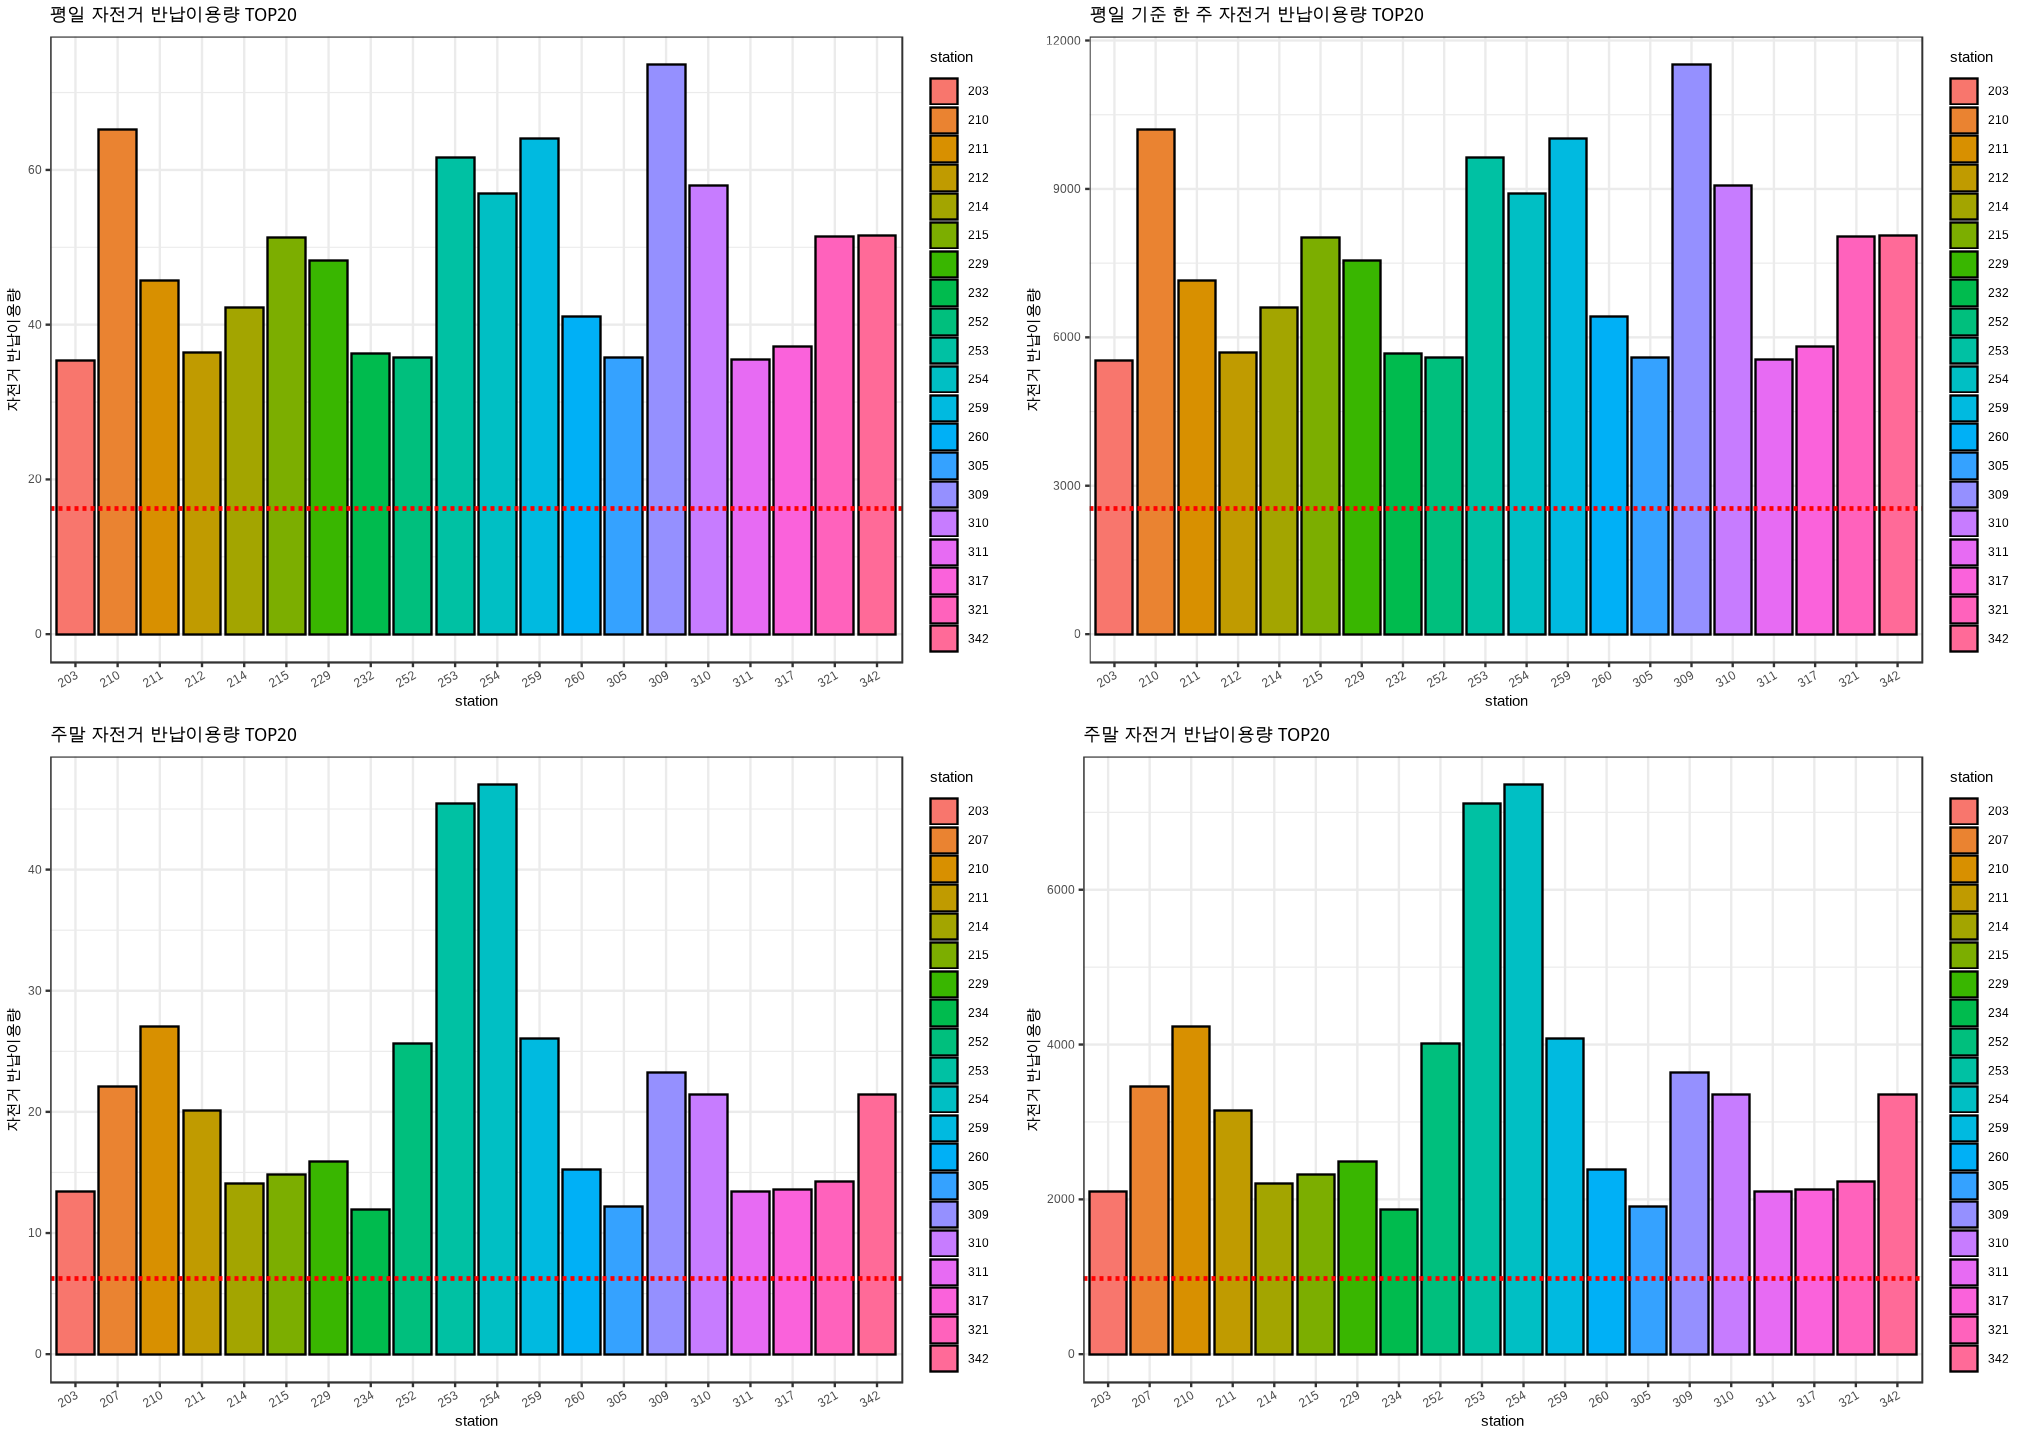

In [155]:
options(repr.plot.width = 17, repr.plot.height = 12)   # 그래프 크기 설정

grid.arrange(p4,q4,p5,q5, ncol=2)

- 하루 기준 평일과 주말 자전거 반납 이용량과 한 주 기준 평일과 주말 자전거 반납 이용량을 비교했을때<br>   TOP20 순위는 비슷하다. 

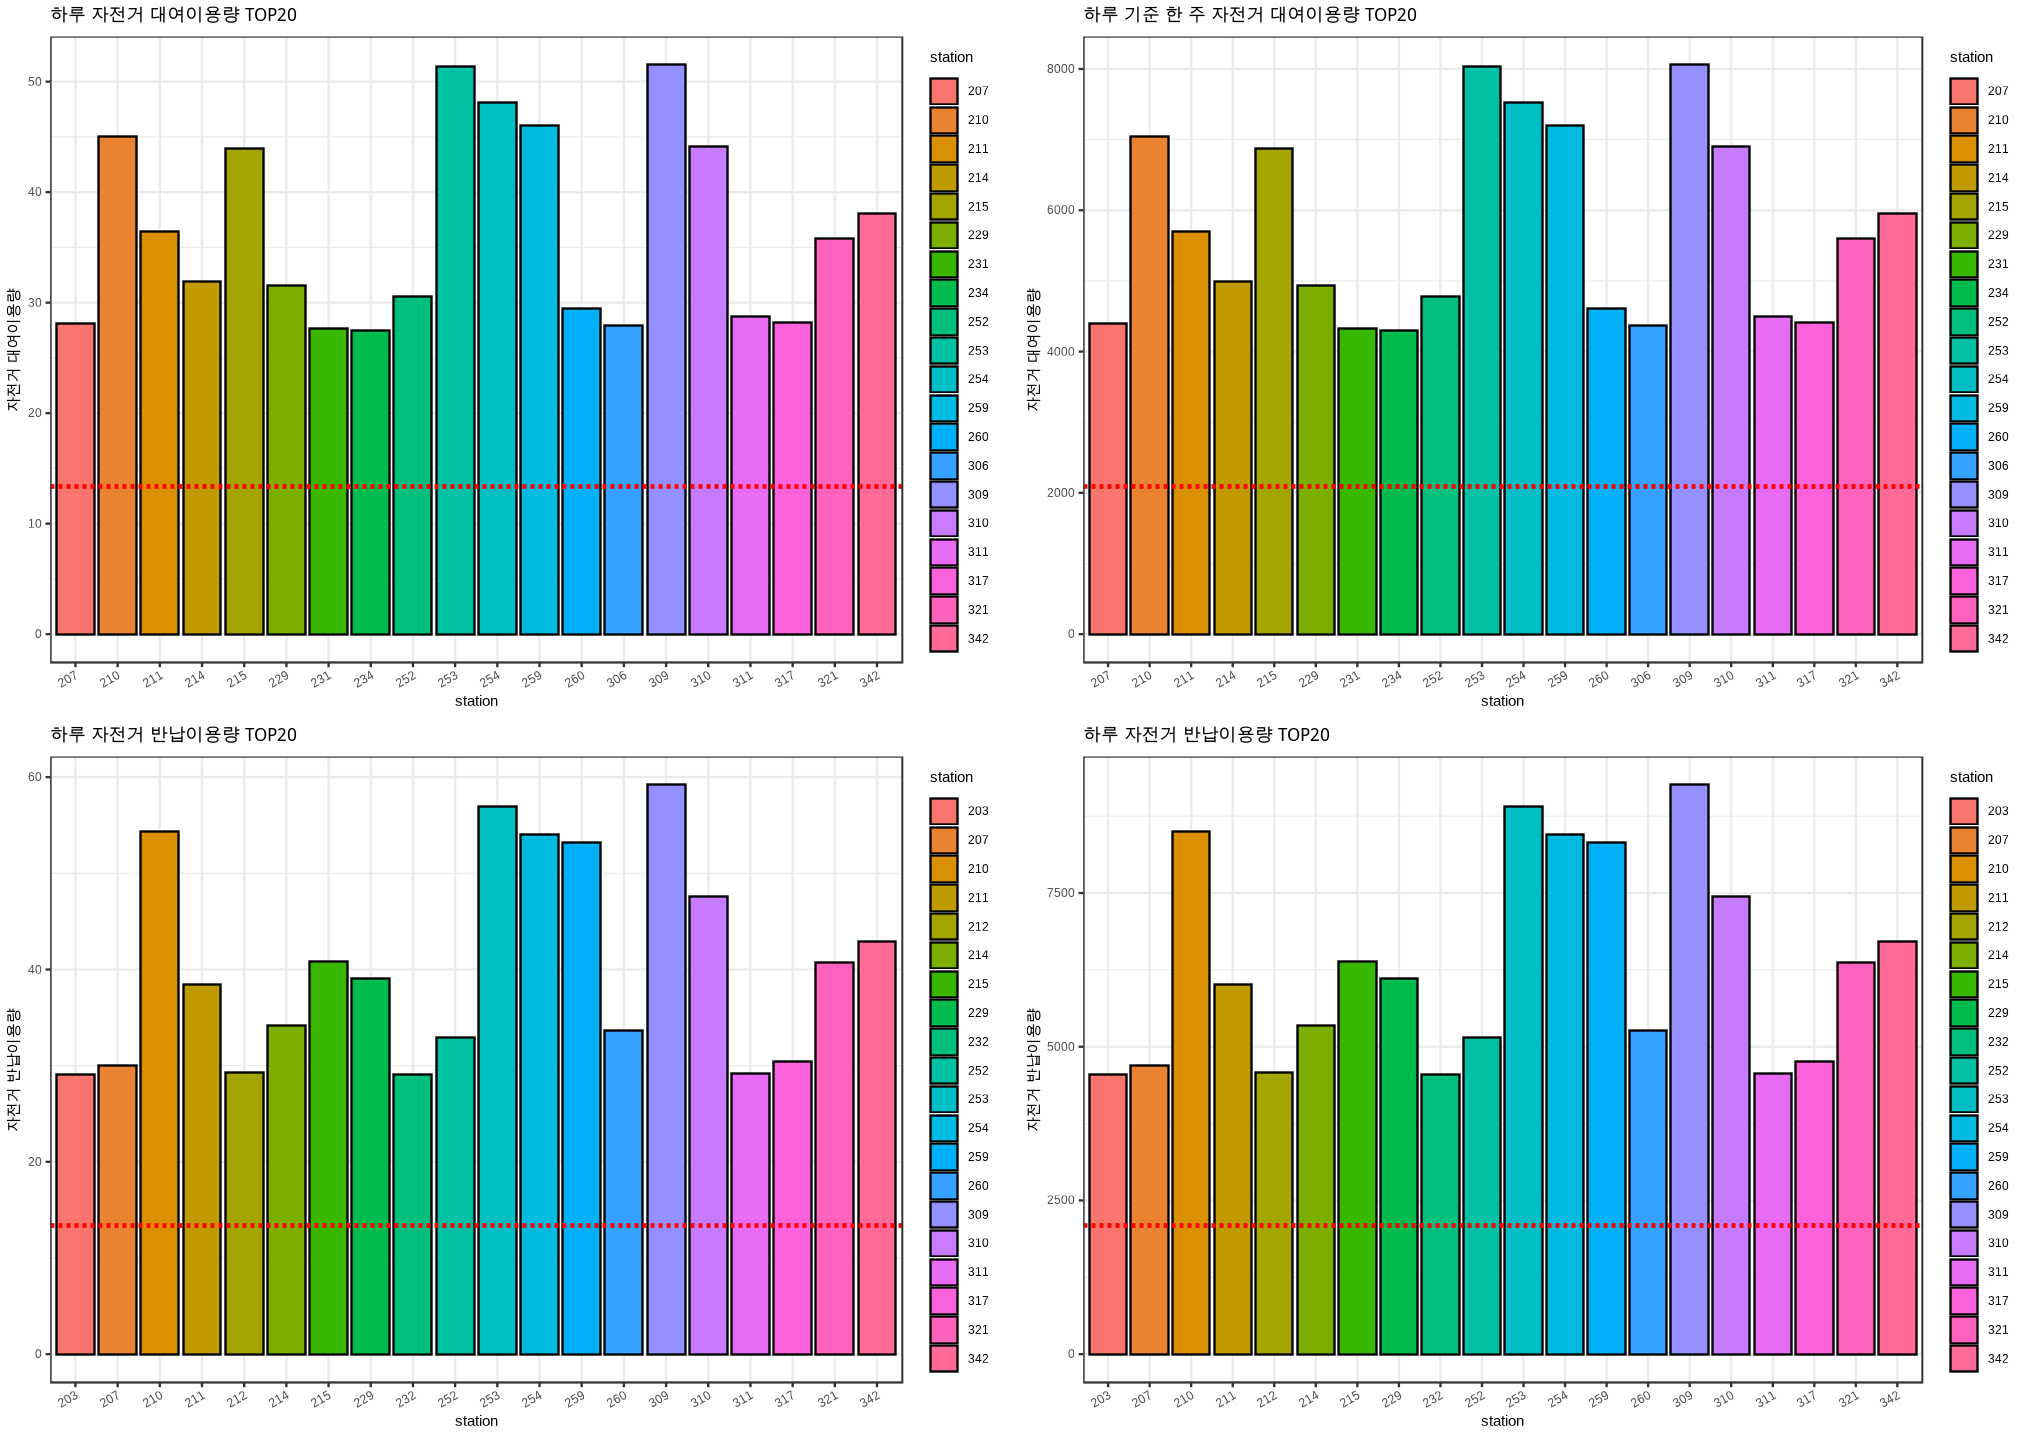

In [156]:
options(repr.plot.width = 17, repr.plot.height = 12)   # 그래프 크기 설정

grid.arrange(p3,q3,p6,q6, ncol=2)

- 하루 기준 자전거 대여,반납 이용량과 한 주 기준 자전거 대여,반납 이용량을 비교했을때<br>   TOP20은 비슷하다.<br><br>
**--> 그래프를 통해 평일과 주말 이용량의 차이가 큰 자전거 스테이션을 확인하여(ex. 309 스테이션)<br>  주말과 평일을 합친 주별 분석을 실시하였다.**

In [157]:
bicycle_use = bicycle_week_use  %>% select(station, mean_day_leas,mean_day_rtn )    # 평일,주말의 자전거 대여,반납 변수 제거함

head(bicycle_use)

,station,mean_day_leas,mean_day_rtn
,<chr>,<dbl>,<dbl>
1,101,862.1143,1104.6857
2,103,428.2571,591.5143
3,104,1403.3714,1131.1714
4,105,261.8857,318.8857
5,106,451.1143,288.0286
6,110,1509.1714,1716.1143


 #  3. QGIS를 이용하여 자전거 스테이션 영향권 (버퍼 200m, 100m)과<br> 다른 변수들간 중첩  

기존 자전거 스테이션에 200m 버퍼 연산을 적용한 후 건물, 버스정류장, 인구분포를, 자전거 스테이션 100m 버퍼 내에 존재하는 지하철역을 각각 중첩하는 과정을 진행하였다. 이를 통해 자전거 스테이션 영향권 안에 존재하는 여러 변수들의 특성에 대해 분석하기 위해 데이터를 QGIS 내의 연산을 통해 가공하였다. <br>
이때, 지하철역의 자전거 스테이션 영향권을 100m로 설정한 이유는, 지하철역 때문에 자전거를 이용하기 위해서는 적어도 100m 반경 이내에 존재해야 한다고 판단하였기 때문이다.<br>
QGIS 연산 과정은 아래와 같다.<br>
이때, DEM(수치표고모델)을 통해 Slope(경사도)를 추출하여 경사도와 자전거 스테이션간의 관계도 분석해 보고자 하였으나, 연산된 데이터에 이상이 있다고 판단하여 사용하지 않았다.

<img src="gis_flowchart_1_신.png">

# 4. 버퍼 200 기준으로 스테이션별 건물 코드 count

#### - qgis 로 자전거 스테이션 기준 버퍼 200을 걸었을때 나오는 건물들을 csv 로 저장(자전거스테이션200X건물도형수정.csv)한 후, 불러옴

In [158]:
# 자전거 스테이션의 buffer200안에 건물용도코드 데이터 정제
stat_bd = fread("자전거스테이션200X건물도형수정.csv", encoding = "UTF-8")

stat_bd

Station_ID,STATION_NA,거치대,BDTYP_CD,BULD_NM,BULD_NM_DC,EMD_CD,GRO_FLO_CO,SIG_CD,UND_FLO_CO
<int>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<int>,<int>,<int>
101,어울림마을 701동 앞,20,10202,,,101,14,41281,4
101,어울림마을 701동 앞,20,3012,,,106,1,41281,0
101,어울림마을 701동 앞,20,10202,,,101,15,41281,4
101,어울림마을 701동 앞,20,16002,,,101,1,41281,0
101,어울림마을 701동 앞,20,3999,,,101,1,41281,0
101,어울림마을 701동 앞,20,3999,,,101,1,41281,0
101,어울림마을 701동 앞,20,1001,,,101,1,41281,0
101,어울림마을 701동 앞,20,3999,동남빌딩,,101,6,41281,0
101,어울림마을 701동 앞,20,3104,고양소방서,,106,1,41281,0


In [159]:
colnames(stat_bd)[1] = "station" 

stat_bd$BDTYP_CD = sprintf("%05d", stat_bd$BDTYP_CD)   # 코드 다섯자리로 표현
sum(is.na(stat_bd))   # 결측치 없음


[1] 0

In [160]:
# 스테이션기준으로 버퍼200을 걸었을때, 그 안에 들어있는 특정건물들 빈도수 측정
stat_bd_cnt = with(stat_bd, table(station, BDTYP_CD)) %>% as.data.frame.matrix 
setDT(stat_bd_cnt, keep.rownames = TRUE)[]

head(stat_bd_cnt)


rn,01001,01002,01003,02001,02002,02003,02004,02005,02006,⋯,17203,17299,17999,19004,19005,19006,19999,21999,90001,90002
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
101,31,1,3,11,0,1,1,2,0,⋯,0,0,0,0,0,0,0,0,0,0
103,19,0,8,35,0,0,3,0,0,⋯,0,0,0,0,0,0,0,0,0,0
104,2,0,0,17,0,0,3,1,0,⋯,0,0,0,0,0,0,0,0,1,0
105,112,0,27,7,7,37,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
106,19,0,1,5,0,26,0,0,0,⋯,0,0,0,0,0,0,0,0,3,0
110,0,0,0,14,0,0,4,0,0,⋯,0,0,0,0,0,0,0,0,0,0
111,0,0,0,28,0,0,2,2,0,⋯,0,0,0,0,0,0,0,0,0,0
112,3,74,41,13,0,0,3,2,0,⋯,0,0,0,0,0,0,0,0,0,0
113,59,53,26,5,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,1


rn,01001,01002,01003,02001,02002,02003,02004,02005,02006,⋯,17203,17299,17999,19004,19005,19006,19999,21999,90001,90002
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
101,31,1,3,11,0,1,1,2,0,⋯,0,0,0,0,0,0,0,0,0,0
103,19,0,8,35,0,0,3,0,0,⋯,0,0,0,0,0,0,0,0,0,0
104,2,0,0,17,0,0,3,1,0,⋯,0,0,0,0,0,0,0,0,1,0
105,112,0,27,7,7,37,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
106,19,0,1,5,0,26,0,0,0,⋯,0,0,0,0,0,0,0,0,3,0
110,0,0,0,14,0,0,4,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [161]:
colnames(stat_bd_cnt)[1] = "station"

head(stat_bd_cnt)

station,01001,01002,01003,02001,02002,02003,02004,02005,02006,⋯,17203,17299,17999,19004,19005,19006,19999,21999,90001,90002
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
101,31,1,3,11,0,1,1,2,0,⋯,0,0,0,0,0,0,0,0,0,0
103,19,0,8,35,0,0,3,0,0,⋯,0,0,0,0,0,0,0,0,0,0
104,2,0,0,17,0,0,3,1,0,⋯,0,0,0,0,0,0,0,0,1,0
105,112,0,27,7,7,37,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
106,19,0,1,5,0,26,0,0,0,⋯,0,0,0,0,0,0,0,0,3,0
110,0,0,0,14,0,0,4,0,0,⋯,0,0,0,0,0,0,0,0,0,0


# 5. 건물용도 코드 대분류

In [162]:
build = fread("건물용도코드_신.csv", encoding = "UTF-8")
#이때 건물용도코드_신.csv 파일은 xlsx로 구성된 코드정의서에서 건물용도코드만을 추출해 csv로 내보내기 한 파일.
build

코드,코드명
<int>,<chr>
1000,단독주택
1001,단독주택
1002,다중주택
1003,다가구주택
1004,공관
2000,공동주택
2001,아파트
2002,연립주택
2003,다세대주택


In [163]:
str(build)

Classes ‘data.table’ and 'data.frame':	324 obs. of  2 variables:
 $ 코드  : int  1000 1001 1002 1003 1004 2000 2001 2002 2003 2004 ...
 $ 코드명: chr  "단독주택" "단독주택" "다중주택" "다가구주택" ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [164]:
build$`코드` = sprintf("%05d", build$`코드`) # 건물용도코드에 '코드'변수 자리수를 5리로 맞추기

build$code_num = substr(build$코드, 1,2)    # 코드변수에서 앞에서 3번째 자리까지 위치하는 숫자 : 대분류 코드숫자

build                                        # 대분류 코드숫자인 code_num 변수에 잘 들어갔음을 확인

코드,코드명,code_num
<chr>,<chr>,<chr>
01000,단독주택,01
01001,단독주택,01
01002,다중주택,01
01003,다가구주택,01
01004,공관,01
02000,공동주택,02
02001,아파트,02
02002,연립주택,02
02003,다세대주택,02


In [165]:
build$코드명[str_sub(build$코드,start = -3) == "000"]

[1] "단독주택"             "공동주택"             "1종근린생활시설"     
 [4] "제2종근린생활시설"    "문화 및 집회시설"     "판매 및 영업시설"    
 [7] "의료시설"             "교육연구 및 복지시설" "운동시설"            
[10] "업무시설"             "숙박시설"             "위락시설"            
[13] "공장"                 "창고시설"             "위험물 저장․처리시설"
[16] "자동차관련시설"       "동․식물관련시설"      "분뇨․쓰레기처리시설" 
[19] "공공용시설"           "묘지관련시설"         "관광휴게시설"

In [166]:
a = data.frame(code_num = sprintf("%02d", 1:21), name = build$코드명[str_sub(build$코드,start = -3) == "000"])

a       # 건물용도 대분류를 number와 이름으로 정리

code_num,name
<fct>,<fct>
01,단독주택
02,공동주택
03,1종근린생활시설
04,제2종근린생활시설
05,문화 및 집회시설
06,판매 및 영업시설
07,의료시설
08,교육연구 및 복지시설
09,운동시설


In [167]:
building = full_join(build, a , by = "code_num")

colnames(building) = c("code", "code_nm", "dae_code", "dae_code_nm")
building    # 건물용도 대분류 최종데이터를 "building" 에 저장.

code,code_nm,dae_code,dae_code_nm
<chr>,<chr>,<chr>,<fct>
01000,단독주택,01,단독주택
01001,단독주택,01,단독주택
01002,다중주택,01,단독주택
01003,다가구주택,01,단독주택
01004,공관,01,단독주택
02000,공동주택,02,공동주택
02001,아파트,02,공동주택
02002,연립주택,02,공동주택
02003,다세대주택,02,공동주택


In [168]:
building[building$dae_code ==17.]

code,code_nm,dae_code,dae_code_nm
<chr>,<chr>,<chr>,<fct>
17000,동․식물관련시설,17,동․식물관련시설
17003,도축장,17,동․식물관련시설
17004,도계장,17,동․식물관련시설
17005,버섯재배사,17,동․식물관련시설
17006,종묘배양시설,17,동․식물관련시설
17007,온실,17,동․식물관련시설
17101,축사,17,동․식물관련시설
17102,양잠,17,동․식물관련시설
17103,양봉,17,동․식물관련시설


# 6. 스테이션200버퍼X버스이용량과<br> 스테이션200버퍼X지하철역 유무 분석과정 

### - 스테이션 별로 200m 버퍼 내에 있는 버스정류장의 이용량 구하기

In [169]:
station_bus = fread("버스정류장X스테이션200.csv", encoding = "UTF-8")

head(station_bus)
colnames(station_bus)

STATION_NM,STATION_ID,X,Y,GETON_CNT,Station__1,STATION_NA,거치대,위도,경도
<chr>,<int>,<dbl>,<dbl>,<chr>,<int>,<chr>,<int>,<dbl>,<dbl>
신일비즈니스고등학교,219000619,126.7606,37.68330,3496.000000000000000,322,★후곡마을1단지 101동 앞,20,37.68453,126.7620
풍동상가단지,219000457,126.8008,37.66719,8060.000000000000000,237,풍동 뜨란체2단지 사거리,25,37.66697,126.8005
중산마을2단지.해태쇼핑.코오롱아파트,219000146,126.7791,37.69376,646.000000000000000,251,중산2단지 사거리,20,37.69379,126.7779
탄현2단지.삼익아파트,219000143,126.7680,37.69360,1037.000000000000000,329,탄현주민센터 앞,20,37.69437,126.7687
삼송마을14.15단지,218000272,126.8812,37.65050,7048.000000000000000,165,삼송마을19단지 후문 사거리,25,37.65032,126.8832
숲속마을7.9단지,219000463,126.8019,37.67261,2410.000000000000000,240,숲속마을로 사거리,20,37.67297,126.8009


[1] "STATION_NM" "STATION_ID" "X"          "Y"          "GETON_CNT" 
 [6] "Station__1" "STATION_NA" "거치대"     "위도"       "경도"

- station_1 : station 번호 / GETON_CNT	 : 버스 이용량

In [170]:
station_bus$STATION_ID = as.character(station_bus$STATION_ID)  # 스테이션 번호 타입을 문자형으로 바꾸기

In [171]:
bus_use21 = fread("21.버스_정류장별_승하차_정보.csv", encoding = "UTF-8")

head(bus_use21)

STATION_ID,STATION_NM,GETON_CNT
<int>,<chr>,<int>
218001046,화정역3호선,229091
218001083,원당역,219186
218000974,화정역3호선,197084
219000193,대화역,191696
219000193,대화역,169990
219000366,대화역,124336


In [172]:
bus_use21$STATION_ID = as.character(bus_use21$STATION_ID) 

bus_use21_1 = bus_use21 %>%  group_by(STATION_ID) %>% dplyr::summarise(GETON_CNT_sum = sum(GETON_CNT))


`summarise()` ungrouping output (override with `.groups` argument)



In [173]:
head(bus_use21_1)

STATION_ID,GETON_CNT_sum
<chr>,<int>
218000001,1
218000002,13
218000003,844
218000004,1368
218000005,2492
218000006,3203


In [174]:
bus_real = left_join(station_bus,bus_use21_1, by = "STATION_ID")

head(bus_real)

STATION_NM,STATION_ID,X,Y,GETON_CNT,Station__1,STATION_NA,거치대,위도,경도,GETON_CNT_sum
<chr>,<chr>,<dbl>,<dbl>,<chr>,<int>,<chr>,<int>,<dbl>,<dbl>,<int>
신일비즈니스고등학교,219000619,126.7606,37.68330,3496.000000000000000,322,★후곡마을1단지 101동 앞,20,37.68453,126.7620,3496
풍동상가단지,219000457,126.8008,37.66719,8060.000000000000000,237,풍동 뜨란체2단지 사거리,25,37.66697,126.8005,8060
중산마을2단지.해태쇼핑.코오롱아파트,219000146,126.7791,37.69376,646.000000000000000,251,중산2단지 사거리,20,37.69379,126.7779,646
탄현2단지.삼익아파트,219000143,126.7680,37.69360,1037.000000000000000,329,탄현주민센터 앞,20,37.69437,126.7687,1037
삼송마을14.15단지,218000272,126.8812,37.65050,7048.000000000000000,165,삼송마을19단지 후문 사거리,25,37.65032,126.8832,7048
숲속마을7.9단지,219000463,126.8019,37.67261,2410.000000000000000,240,숲속마을로 사거리,20,37.67297,126.8009,2410


In [175]:
# bus_real 에서 스테이션 번호, 하루 평균 버스 이용량 변수만 추출한 후 같은 스테이션끼리 이용량 합하기
bus_real = bus_real %>%  select(Station__1, GETON_CNT_sum) %>% ddply(.(Station__1), summarise, bus_user = sum(GETON_CNT_sum)) 

#### 기존 스테이션 별 하루 평균 버스 이용량 최종 데이터

In [176]:
bus_real = na.omit(bus_real)

head(bus_real)

,Station__1,bus_user
,<int>,<int>
1,101,22817
2,103,12482
3,104,38122
4,105,57388
5,106,241438
6,110,799


In [177]:
colnames(bus_real)[1] = "station"

In [178]:
head(bus_real); dim(bus_real)

,station,bus_user
,<int>,<int>
1,101,22817
2,103,12482
3,104,38122
4,105,57388
5,106,241438
6,110,799


[1] 144   2

#### - station별로 버퍼 100m 걸었을때 지하철이 있는 station을 q-gis로 구한 후 csv로 저장함 ( "전철역X스테이션100.csv" )

In [179]:
station_subway = fread("전철역X스테이션100.csv", encoding = "UTF-8")

head(station_subway)

rail_nm,station_nm,lot_num_ad,road_nm_ad,X,Y,Station_ID,STATION_NA,거치대,위도,경도
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<int>,<dbl>,<dbl>
3호선,대화,경기도 고양시 일산서구 대화동 2221,경기도 고양시 일산서구 중앙로 지하 1569,126.7472,37.67585,305,★대화역 6번 출구,20,37.67612,126.7481
3호선,대화,경기도 고양시 일산서구 대화동 2221,경기도 고양시 일산서구 중앙로 지하 1569,126.7472,37.67585,306,대화역 1번 출구,30,37.67584,126.7480
경의중앙,일산,경기도 고양시 일산서구 일산동 655-691,경기도 고양시 일산서구 경의로 672,126.7701,37.68201,321,★일산역 신도시 방면,25,37.68181,126.7693
경의중앙,일산,경기도 고양시 일산서구 일산동 655-691,경기도 고양시 일산서구 경의로 672,126.7701,37.68201,340,일산역 본일산 방면,30,37.68251,126.7699
3호선,백석,경기도 고양시 일산동구 백석동 1538,경기도 고양시 일산동구 중앙로 지하 1042,126.7881,37.64295,203,★백석역 3번 출구 앞,20,37.64288,126.7876
경의중앙,백마,경기도 고양시 일산동구 백석동 92,경기도 고양시 일산동구 경의로 318,126.7941,37.65843,233,백마역,25,37.65869,126.7939


In [180]:
# station_subway 을 이용하여 기존 자전거 스테이션 주위 지하철유무 변수 추가
bus_real$subway_OX = ifelse(bus_real$station %in% station_subway$Station_ID , "O", "X")  

station_traff = bus_real

station_traff

,station,bus_user,subway_OX
,<int>,<int>,<chr>
1,101,22817,X
2,103,12482,X
3,104,38122,X
4,105,57388,X
5,106,241438,O
6,110,799,X
7,111,46706,X
8,112,43310,X
9,113,168,X


### - 위에서 구한 버퍼 200기준 스테이션별 건물 개수데이터(stat_bd_cnt)와 조인

In [181]:
station_traff$station = as.character(station_traff$station)   # station 변수 타입을 정수형에서 문자형으로  변환

In [182]:
finall = stat_bd_cnt %>% left_join(station_traff, by = "station") %>% left_join(bicycle_use, by = "station")

In [183]:
head(finall)

station,01001,01002,01003,02001,02002,02003,02004,02005,02006,⋯,19005,19006,19999,21999,90001,90002,bus_user,subway_OX,mean_day_leas,mean_day_rtn
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>
101,31,1,3,11,0,1,1,2,0,⋯,0,0,0,0,0,0,22817,X,862.1143,1104.6857
103,19,0,8,35,0,0,3,0,0,⋯,0,0,0,0,0,0,12482,X,428.2571,591.5143
104,2,0,0,17,0,0,3,1,0,⋯,0,0,0,0,1,0,38122,X,1403.3714,1131.1714
105,112,0,27,7,7,37,0,0,0,⋯,0,0,0,0,0,0,57388,X,261.8857,318.8857
106,19,0,1,5,0,26,0,0,0,⋯,0,0,0,0,3,0,241438,O,451.1143,288.0286
110,0,0,0,14,0,0,4,0,0,⋯,0,0,0,0,0,0,799,X,1509.1714,1716.1143


 # 7. lasso regression을 이용하여 자전거이용량에 영향을 미치는 변수<br>    (건물그룹, 지하철역 유무, 버스정류장 이용량)  찾기

다중선형회귀모형에서의 변수 감소율측면에서<br>
lasso regression , 단계적 선택법 , 후방 소거법 , 전진 선택법 , elasticnet , 유전자 알고리즘 , ridge regression 순으로<br>
변수가 효율적으로 감소된다는 논문결과를 참고하여<br>
우리는 변수들 중 자전거이용량에 영향을 미치는 변수를 찾기 위하여 lasso regression 기법을 선택했다.


### - 스테이션별 건물개수 데이터(finall)에서 건물들을 대분류(building)로 묶기

In [184]:
dim(finall) ; colnames(finall)

[1] 163 143

[1] "station"       "01001"         "01002"         "01003"        
  [5] "02001"         "02002"         "02003"         "02004"        
  [9] "02005"         "02006"         "02007"         "03001"        
 [13] "03002"         "03003"         "03004"         "03005"        
 [17] "03007"         "03008"         "03012"         "03013"        
 [21] "03014"         "03015"         "03100"         "03101"        
 [25] "03102"         "03103"         "03104"         "03105"        
 [29] "03106"         "03108"         "03109"         "03199"        
 [33] "03999"         "04001"         "04002"         "04004"        
 [37] "04005"         "04006"         "04007"         "04008"        
 [41] "04010"         "04012"         "04016"         "04017"        
 [45] "04018"         "04022"         "04102"         "04107"        
 [49] "04199"         "04201"         "04202"         "04203"        
 [53] "04299"         "04399"         "04401"         "04402"        
 [57] "04403"         "04499"         "04505"         "04999"        
 [61] "05101"         "05102"         "05107"         "05108"        
 [65] "05199"         "05403"         "05404"         "05499"        
 [69] "05501"         "05599"         "05999"         "06100"        
 [73] "06202"         "06203"         "06204"         "06205"        
 [77] "06301"         "06303"         "06305"         "06310"        
 [81] "06999"         "07101"         "07102"         "07104"        
 [85] "07107"         "07199"         "07999"         "08001"        
 [89] "08003"         "08005"         "08101"         "08102"        
 [93] "08103"         "08201"         "08202"         "08203"        
 [97] "08204"         "08300"         "08400"         "08500"        
[101] "08601"         "08999"         "09999"         "10102"        
[105] "10199"         "10201"         "10202"         "10204"        
[109] "10299"         "11101"         "11102"         "11199"        
[113] "11201"         "11299"         "12999"         "13100"        
[117] "14001"         "14999"         "15001"         "15006"        
[121] "15009"         "15999"         "16001"         "16002"        
[125] "16004"         "16005"         "16006"         "16999"        
[129] "17007"         "17203"         "17299"         "17999"        
[133] "19004"         "19005"         "19006"         "19999"        
[137] "21999"         "90001"         "90002"         "bus_user"     
[141] "subway_OX"     "mean_day_leas" "mean_day_rtn"

In [185]:
building = building[building$code %in% colnames(finall[,-c(1,140:143)]) ]

building

code,code_nm,dae_code,dae_code_nm
<chr>,<chr>,<chr>,<fct>
01001,단독주택,01,단독주택
01002,다중주택,01,단독주택
01003,다가구주택,01,단독주택
02001,아파트,02,공동주택
02002,연립주택,02,공동주택
02003,다세대주택,02,공동주택
02004,생활편익시설,02,공동주택
02005,부대시설,02,공동주택
02006,복리시설,02,공동주택


- 건물 대분류 코드 1~21번 중 finall 데이터 기준으로 건물 대분류 코드를 정제한 결과<br>   건물 대분류 코드 18,20번이 제거되었다.

#### finall 데이터에서 건물코드를 대분류 기준으로 묶기

In [186]:
aa = list()

for(i in 1 : length(unique(building$dae_code))){
    
    aa[[i]] = building$code[building$dae_code == unique(building$dae_code)[i]]
    
}

In [187]:
aa  # 건물코드 대분류 기준으로 건물코드를 분류한 결과

[[1]]
[1] "01001" "01002" "01003"

[[2]]
[1] "02001" "02002" "02003" "02004" "02005" "02006" "02007"

[[3]]
 [1] "03001" "03002" "03003" "03004" "03005" "03007" "03008" "03012" "03013"
[10] "03014" "03015" "03100" "03101" "03102" "03103" "03104" "03105" "03106"
[19] "03108" "03109" "03199" "03999"

[[4]]
 [1] "04001" "04002" "04004" "04005" "04006" "04007" "04008" "04010" "04012"
[10] "04016" "04017" "04018" "04022" "04102" "04107" "04199" "04201" "04202"
[19] "04203" "04299" "04399" "04401" "04402" "04403" "04499" "04999"

[[5]]
 [1] "05101" "05102" "05107" "05108" "05199" "05403" "05404" "05499" "05501"
[10] "05599" "05999"

[[6]]
 [1] "06100" "06202" "06203" "06204" "06205" "06301" "06303" "06305" "06310"
[10] "06999"

[[7]]
[1] "07101" "07102" "07104" "07107" "07999"

[[8]]
 [1] "08001" "08003" "08005" "08101" "08102" "08103" "08201" "08202" "08003"
[10] "08204" "08300" "08400" "08500" "08601" "08999"

[[9]]
[1] "09999"

[[10]]
[1] "10102" "10199" "10201" "10202" "10204" "10299"

[[11]]
[1] "11101" "11102" "11199" "11201" "11299"

[[12]]
[1] "12999"

[[13]]
[1] "13100"

[[14]]
[1] "14001" "14999"

[[15]]
[1] "15001" "15006" "15009" "15999"

[[16]]
[1] "16001" "16002" "16004" "16005" "16006" "16999"

[[17]]
[1] "17007" "17203" "17299" "17999"

[[18]]
[1] "19004" "19005" "19006" "19999"

[[19]]
[1] "21999"

In [188]:
dim(finall)   # 163행 143열


[1] 163 143

In [189]:
final_1 = finall[,-c(1,140:143)]    # 건물코드만 따로 분류
head(final_1)

01001,01002,01003,02001,02002,02003,02004,02005,02006,02007,⋯,17203,17299,17999,19004,19005,19006,19999,21999,90001,90002
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
31,1,3,11,0,1,1,2,0,0,⋯,0,0,0,0,0,0,0,0,0,0
19,0,8,35,0,0,3,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,0,0,17,0,0,3,1,0,0,⋯,0,0,0,0,0,0,0,0,1,0
112,0,27,7,7,37,0,0,0,1,⋯,0,0,0,0,0,0,0,0,0,0
19,0,1,5,0,26,0,0,0,0,⋯,0,0,0,0,0,0,0,0,3,0
0,0,0,14,0,0,4,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [190]:
final_data = matrix(NA, nrow = 163, ncol = 19)

for(i in 1 : length(aa)){
    
    final_data[,i] = final_1 %>%  select(which(colnames(final_1) %in% aa[[i]]))  %>% 
               apply(1,sum) 
}

head(final_data)

35,15,26,21,1,0,0,0,0,2,2,0,0,2,0,1,0,0,0
27,38,1,9,0,0,0,4,0,0,0,0,0,7,0,0,0,0,0
2,21,2,4,0,0,0,2,0,0,0,0,0,3,0,0,0,0,0
139,52,14,29,1,1,0,6,0,2,0,0,0,17,0,2,0,0,0
20,31,10,6,0,3,0,0,0,0,0,0,0,6,0,1,1,0,0
0,18,1,1,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [191]:
final_data = data.frame(final_data)
colnames(final_data) = paste0("group", c(1:17,19,21))
final_data$bus_user = finall$bus_user
final_data$subway = as.factor(finall$subway_OX)
final_data$mean_day_leas = finall$mean_day_leas
final_data$mean_day_rtn = finall$mean_day_rtn

final_data = na.omit(final_data)

### lasso regression 에 이용할 최종 데이터 도출

In [192]:
final_data

,group1,group2,group3,group4,group5,group6,group7,group8,group9,group10,⋯,group14,group15,group16,group17,group19,group21,bus_user,subway,mean_day_leas,mean_day_rtn
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<dbl>,<dbl>
1,35,15,26,21,1,0,0,0,0,2,⋯,2,0,1,0,0,0,22817,X,862.1143,1104.6857
2,27,38,1,9,0,0,0,4,0,0,⋯,7,0,0,0,0,0,12482,X,428.2571,591.5143
3,2,21,2,4,0,0,0,2,0,0,⋯,3,0,0,0,0,0,38122,X,1403.3714,1131.1714
4,139,52,14,29,1,1,0,6,0,2,⋯,17,0,2,0,0,0,57388,X,261.8857,318.8857
5,20,31,10,6,0,3,0,0,0,0,⋯,6,0,1,1,0,0,241438,O,451.1143,288.0286
6,0,18,1,1,4,0,0,1,0,0,⋯,0,0,0,0,0,0,799,X,1509.1714,1716.1143
7,0,32,2,0,0,0,3,2,0,0,⋯,0,0,0,0,0,0,46706,X,1012.5714,1076.5714
8,118,18,0,3,0,0,3,2,0,0,⋯,0,0,0,0,0,0,43310,X,840.7429,800.4286
9,138,5,3,27,1,1,0,3,0,1,⋯,6,1,0,0,0,0,168,X,1269.2571,1215.2000


- 하루 대여 이용량과 건물,버스 이용량, 지하철 유무 와의 관계를 알아볼 때<br>   Y : 하루 대여 이용량(mean_day_leas) / X : 그룹1~19, 버스이용량, 지하철 유무
- 하루 반납 이용량과 건물,버스 이용량, 지하철 유무 와의 관계를 알아볼 때<br>   Y : 하루 반납 이용량(mean_day_rtn) / X : 그룹1~19, 버스이용량, 지하철 유무

## lasso regression

In [193]:
# 하루 대여 이용량에 대해
y_leas = final_data$mean_day_leas
x = data.matrix(final_data[,1:21])

lambdas = seq(0, 0.5, by = 0.5)      # lambda 를 0과 0.5 사이의 값으로 설정
cv_fit_leas = cv.glmnet(x,y_leas, alpha = 1, lambda = lambdas)

opt_lambdas_leas = cv_fit_leas$lambda.min

fin_leas = glmnet(x,y_leas, alpha = 1, lambda = opt_lambdas_leas)
coef(fin_leas)   # 하루 대여 이용량에 영향을 미치는 변수들 추출


22 x 1 sparse Matrix of class "dgCMatrix"
                          s0
(Intercept)  3408.3373439718
group1          3.8438965069
group2          3.9144675875
group3        -36.0759924053
group4        -10.7655246863
group5         76.3899028379
group6        207.6577436331
group7         11.1906831443
group8        -11.9467403556
group9          .           
group10       238.9290814437
group11        66.4620652213
group12       562.1711644443
group13     -1031.5231659411
group14       -25.7959545573
group15       -45.5457346798
group16      -239.3010660887
group17      -150.5937200136
group19       197.3683132071
group21     -1902.7628464008
bus_user        0.0003245658
subway       -839.7464283129

- ↑하루 대여 이용량에 대해 lasso regression 분석을 한 coefficient 결과값

In [194]:
# 하루 반납 이용량에 대해
y_rtn = final_data$mean_day_rtn
x = data.matrix(final_data[,1:21])

lambdas = seq(0, 0.5, by = 0.5)      # lambda 를 0과 0.5 사이의 값으로 설정
cv_fit_rtn = cv.glmnet(x,y_rtn, alpha = 1, lambda = lambdas)

opt_lambdas_rtn = cv_fit_rtn$lambda.min

fin_rtn = glmnet(x,y_rtn, alpha = 1, lambda = opt_lambdas_rtn)
coef(fin_rtn)   # 하루 반납 이용량에 영향을 미치는 변수들 추출


22 x 1 sparse Matrix of class "dgCMatrix"
                          s0
(Intercept)  3668.4442205664
group1          2.0841444165
group2          2.9628633945
group3        -32.6694714364
group4         -4.7197569407
group5         98.0538742913
group6        255.0260037503
group7        -17.3588448333
group8        -15.7488768699
group9          .           
group10       291.5558828601
group11        71.3600633337
group12       305.0436621109
group13     -1390.1539099995
group14       -21.9968625991
group15        61.9160990981
group16      -276.0839108485
group17      -135.3511771174
group19       106.9556111705
group21     -1884.6284200490
bus_user       -0.0002349877
subway      -1004.3485656492

- ↑하루 대여 이용량에 대해 lasso regression 분석을 한 coefficient 결과값

# 8. QGIS를 활용한 신규 자전거 Station 적지 선정 및 이용예측량 추정을 위한 전처리

##  - QGIS에서 LASSO 값에 따라 (+)값을 가지는 변수를 유의미한 변수로 판단하여, 해당 변수를 레이어로 추출하여 버퍼200, 그들간 겹치는 지역 추출

Union Layer 기준: Lasso 값이 크고, 레이어 당 객체 개수가 적은 것<br>
Intersect Layer 기준: 객체 개수가 많은 순서대로 Intersect를 진행


### 대여
(지하철∪위락시설∪운동시설∪업무시설) ∩ 단독 ∩ 문화 ∩ 판매 ∩ 공공용시설 ∩ 의료

<img src="gis_flowchart_2_대여.png">


### 반납
(운동∪지하철∪위락시설∪업무시설) ∩ 단독 ∩ 2종 ∩ 문화 ∩ 판매 ∩ 위험물 

<img src="gis_flowchart_3_반납.png">

### 스테이션이 위치할 도로 범위 추출
스테이션은 차가 달리는 도로에 위치할 수 없으며 주로 사람이 다니는 인도에 위치한다. 따라서 line으로 이루어진 인도와 도로 자료에 버퍼 연산을 적용하여 스테이션이 위치할 수 있는 범위를 구하고자 하였다. <br>
정확한 인도 데이터가 있었다면 이를 통해서만 활용하면 되었겠지만, 데이터를 실제 위성영상과 비교해 본 결과, 실제 인도가 있는 지역에 인도 데이터가 없는 지역이 있었고, polygon data가 아닌 line data로 오차도 있을 것이라 판단하여, 이를 극복하기 위해 도로 데이터에서 일련의 연산과정을 진행하여 이를 같이 고려해 주었다.

#### 도로
도로의 중심이 line으로 주어졌기 때문에 line에 20m와 10m 버퍼 연산을 진행한 후 두 레이어를 erase 해주었다.

#### 인도 
인도 역시 line으로 이루어졌기 때문에 3m 버퍼연산을 하여 대략적인 인도의 폭을 생성하였다.

<img src="gis_flowchart_4_수정.png">



### 대여 반납 레이어 Union
중첩된 개수를 기준으로 i6, i5, i4, i3, i2라 하였으며,
각각 5, 4, 3, 2, 1의 점수를 부여하였다.<br>
이후 반납 Score와 대여 Score를 합한 Score_sum 필드를 생성하였다.

<img src="gis_flowchart_5.png">

### 스테이션 위치 Point 추출
앞서 생성하였던 도로와 인도 범위와 score_sum이 포함된 I65432 대여 반납 레이어를 각각 중첩하여 스테이션이 위치할 영역(Polygon)을 추출하였다. <br>
위 결과를 바탕으로 QGIS의 중심점 연산을 진행하였다<br>이때 중심점 알고리즘은 폴리곤으로 이루어진 객체의 중심점에 위치한 point를 추출하는 알고리즘이다.<br><br>
[ { 도로 버퍼20(디졸브) - 도로 버퍼10(디졸브) }  ∩ ( 대여 ∪ 반납 ) ] ∪ { 인도 ∩ ( 대여 ∪ 반납 ) } 

<img src="gis_flowchart_6.png">

그 결과 1770개의 point가 추출 되었으며 이에 따라 우리는 K-mean Clustering 알고리즘을 이용했다.<br>
Clustring 그룹 개수는 1000, 700, 500, 300, 250, 225, 200을 순차적으로 진행하며 클러스터링 그룹별로 1개 씩 추출하며 그 분포를 살펴보고 추출된 객체를 기준으로 다시 더 적은 클러스터링 그룹으로 나누는 과정을 반복하며, 최종 200을 선택하였다.<br><br>
클러스터링 과정은 다음과 같다.<br>
K-mean Clustring -> Clustering 그룹별 Score_sum 최대값을 선택 -> 선택된 객체 저장 -> 각 그룹별로 중복되는 값이 모두 존재 하므로 그룹 별 하나의 객체를 추출하기위해, ID필드를 생성 -> ID를 기준으로 ID값이 가장 작은 하나를 임의 추출 ->  선택된 객체 저장<br>
이와 같은 과정을 반복하였다.

<img src="gis_flowchart_7.png">


이렇게 클러스터링으로 200개의 객체를 추출하였으나, 오차를 포함하였기 때문에 위성영상을 레이어에 추가하여, 이를 고려하여 이상 점을 찾아 point 제거를 진행하였다.<br>
이 후 station간 연계성을 위해 제작자의 판단을 통해 적절한 위치에 point를 생성, 또 수도권 광역급행철도(GTX)와의 접근성을 고려하여 새로 만들어질 킨텍스역 근처에 자전거 스테이션을 짓는다면, 그 효과가 충분히 기대될 것으로 판단하여 point 생성하였다.<br><br>
제공된 습지보호지역지역 레이어를 이용해 자전거 스테이션에 습지보호구역이 포함되지 않도록 하였다.

<img src="gis_flowchart_8.png">

이렇게 만들어진 Station의 고유 ID인 UFID필드를 생성하였다.<br><br>
Station별 버퍼 200m, 100m(EPSG:5186)을 생성하였고, 건물 대분류코드, 버스정류장, 지하철역과 각각 Intersect 하여 새롭게 생성된 station의 예측 이용량을 분석할 수 있도록 했다.

<img src="gis_flowchart_9.png">

# 9. 위의 lasso regression model을 통해 새로 세운 station의 자전거 이용량 예측

### - 새로 세운 station에서 버퍼 200을 걸었을때 있는 건물들 개수 파악하기

In [195]:
build_use = fread("최종버퍼200_건물대분류_교차.csv", encoding = "UTF-8")

head(build_use)  

score,score_2,score_sum,C200,ID200,lat,lon,id,UFID,BDTYP_CD,⋯,GRO_FLO_CO,SIG_CD,UND_FLO_CO,BDTYP_CD_M,WD_RENT,WE_RENT,D_RENT,WD_RETURN,WE_RETURN,D_RETURN
<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
25,0,25,109,0,37.6614,126.7689,NA,0,14999,⋯,4,41285,1,14,NA,NA,NA,NA,NA,NA
25,0,25,109,0,37.6614,126.7689,NA,0,10202,⋯,10,41285,0,10,275.09,124.27,231.99,195.72,122.55,246.16
25,0,25,109,0,37.6614,126.7689,NA,0,10202,⋯,10,41285,0,10,275.09,124.27,231.99,195.72,122.55,246.16
25,0,25,109,0,37.6614,126.7689,NA,0,3999,⋯,4,41285,0,3,NA,NA,NA,NA,NA,NA
25,0,25,109,0,37.6614,126.7689,NA,0,5999,⋯,4,41285,0,5,153.90,53.03,125.24,160.25,48.33,128.19
25,0,25,109,0,37.6614,126.7689,NA,0,14999,⋯,4,41285,1,14,NA,NA,NA,NA,NA,NA


- BDTYP_CD_M : 위에서 건물 대분류했을때 code number / UFID : 새로 세운 station number

In [196]:
table(build_use$BDTYP_CD_M)   # 대분류코드에 90이 있는것을 확인함. -> 제거하기


   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
7369 2464 1209 1283   88  115   17  240   63  266   26    3   62 1531   33   95 
  17   18   19   20   21   90 
 293   19   23    6    1   86 

In [197]:
build_use = build_use[build_use$BDTYP_CD_M != 90,]

table(build_use$BDTYP_CD_M)   # 대분류코드에 90이 잘 제거되었음을 확인함.


   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
7369 2464 1209 1283   88  115   17  240   63  266   26    3   62 1531   33   95 
  17   18   19   20   21 
 293   19   23    6    1 

In [198]:
build_pred = build_use  %>%  dplyr::select(UFID,BDTYP_CD_M) %>%  with( table(UFID, BDTYP_CD_M))  %>% as.data.frame.matrix()

rownames(build_pred)

[1] "0"   "1"   "2"   "3"   "4"   "5"   "6"   "7"   "8"   "9"   "10"  "11" 
 [13] "12"  "13"  "14"  "15"  "16"  "17"  "18"  "19"  "20"  "21"  "22"  "23" 
 [25] "24"  "25"  "26"  "27"  "28"  "29"  "30"  "31"  "32"  "33"  "34"  "35" 
 [37] "36"  "37"  "38"  "39"  "40"  "41"  "42"  "43"  "44"  "45"  "46"  "47" 
 [49] "48"  "49"  "50"  "51"  "52"  "53"  "54"  "55"  "56"  "57"  "58"  "59" 
 [61] "60"  "61"  "62"  "63"  "64"  "65"  "66"  "67"  "68"  "69"  "70"  "71" 
 [73] "72"  "73"  "74"  "75"  "76"  "77"  "78"  "79"  "80"  "81"  "82"  "83" 
 [85] "84"  "85"  "86"  "87"  "88"  "89"  "90"  "91"  "92"  "93"  "94"  "95" 
 [97] "96"  "97"  "98"  "99"  "100" "101" "102" "103" "104" "105" "106" "107"
[109] "108" "109" "110" "111" "112" "113" "114" "115" "116" "117" "118" "119"
[121] "120" "121" "122" "123" "124" "125" "126" "127" "128" "129" "130" "131"
[133] "132" "133" "134" "135" "136" "137" "138" "139" "140" "141" "142" "143"
[145] "144" "145" "146" "147" "148" "149" "150" "151" "152" "153" "154" "155"
[157] "156" "157" "158" "159" "160" "161" "162" "163" "164" "165" "166" "167"
[169] "168" "169" "170" "171" "172" "173" "174" "175" "176" "177" "178" "179"
[181] "180" "181" "182" "183" "184" "185" "186" "187" "188" "189" "190" "191"
[193] "192" "193" "194" "195" "196" "197" "198" "199" "200" "201" "202" "203"
[205] "204" "205" "206" "207"

In [199]:
build_pred$UFID = rownames(build_pred)

build_pred

,1,2,3,4,5,6,7,8,9,10,⋯,13,14,15,16,17,18,19,20,21,UFID
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
0,1,0,10,8,5,1,1,0,0,10,⋯,0,2,0,2,0,0,1,0,0,0
1,1,1,5,2,3,1,1,1,0,8,⋯,0,3,0,1,0,0,1,0,0,1
2,105,0,27,3,1,2,0,0,0,0,⋯,0,29,1,0,0,0,0,0,0,2
3,76,33,8,27,1,1,0,1,0,0,⋯,0,9,1,3,0,0,0,0,0,3
4,1,8,3,26,1,1,0,4,0,5,⋯,0,5,1,1,0,0,0,0,0,4
5,247,3,4,9,1,1,0,3,0,2,⋯,0,1,1,0,0,0,0,0,0,5
6,2,0,5,1,1,1,0,0,0,1,⋯,1,0,0,1,0,0,1,0,0,6
7,37,45,1,11,1,1,0,2,0,1,⋯,0,1,0,0,0,0,0,0,0,7
8,194,5,6,9,1,2,0,4,0,1,⋯,0,4,0,2,0,0,0,0,0,8


### - 새로 세운 station에서 버퍼 200을 걸었을때 있는 버스의 이용량과 지하철 유무 파악하기

#### 새로 세운 station에서의 하루 버스 평균 이용량 구하기

In [200]:
# 새로 세운 스테이션과 버퍼200m 기준으로  있는 버스정류장 교차작업 한 후 
# g-gis 로 데이터를 저장(버스_최종버퍼200_교차영역.csv)한 후 불러옴
bus_pred = fread("버스_최종버퍼200_교차영역.csv", encoding = "UTF-8")   

bus_pred$STATION_ID = as.character(bus_pred$STATION_ID)
bus_pred$UFID = as.character(bus_pred$UFID)
head(bus_pred)

STATION_NM,STATION_ID,X,Y,score,score_2,score_sum,C200,ID200,lat,lon,id,UFID
<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<chr>
문촌마을14.19단지,219000624,126.7525,37.67101,4,0,4,163,117,37.67099,126.7503,NA,109
문촌마을14.19단지,219000624,126.7525,37.67101,4,0,4,111,125,37.67264,126.7526,NA,117
문촌마을14.19단지,219000623,126.7525,37.67145,4,0,4,163,117,37.67099,126.7503,NA,109
문촌마을14.19단지,219000623,126.7525,37.67145,4,0,4,111,125,37.67264,126.7526,NA,117
삼송테크노밸리,218000219,126.9003,37.64937,20,0,20,36,6,37.64826,126.9020,NA,6
삼송테크노밸리,218000219,126.9003,37.64937,2,0,2,118,188,37.65042,126.8989,NA,173


In [201]:
bus = fread("21.버스_정류장별_승하차_정보.csv", encoding = "UTF-8")

bus$STATION_ID = as.character(bus$STATION_ID)
bus

STATION_ID,STATION_NM,GETON_CNT
<chr>,<chr>,<int>
218001046,화정역3호선,229091
218001083,원당역,219186
218000974,화정역3호선,197084
219000193,대화역,191696
219000193,대화역,169990
219000366,대화역,124336
219000370,마두역(중),109163
219000356,일산동구청(중),106132
218001200,삼송역8번출구,102704


In [202]:
bus_1 = bus %>%  group_by(STATION_ID) %>% dplyr::summarise(GETON_CNT_sum = sum(GETON_CNT))

head(bus_1)

`summarise()` ungrouping output (override with `.groups` argument)



STATION_ID,GETON_CNT_sum
<chr>,<int>
218000001,1
218000002,13
218000003,844
218000004,1368
218000005,2492
218000006,3203


- STATION_ID : 새로 세운 station number / GETON_CNT_sum : 버스정류장  총 이용량

In [203]:
bus_use_pred = left_join(bus_pred,bus_1, by = "STATION_ID")

bus_use_pred

STATION_NM,STATION_ID,X,Y,score,score_2,score_sum,C200,ID200,lat,lon,id,UFID,GETON_CNT_sum
<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<chr>,<int>
문촌마을14.19단지,219000624,126.7525,37.67101,4,0,4,163,117,37.67099,126.7503,NA,109,NA
문촌마을14.19단지,219000624,126.7525,37.67101,4,0,4,111,125,37.67264,126.7526,NA,117,NA
문촌마을14.19단지,219000623,126.7525,37.67145,4,0,4,163,117,37.67099,126.7503,NA,109,298
문촌마을14.19단지,219000623,126.7525,37.67145,4,0,4,111,125,37.67264,126.7526,NA,117,298
삼송테크노밸리,218000219,126.9003,37.64937,20,0,20,36,6,37.64826,126.9020,NA,6,2342
삼송테크노밸리,218000219,126.9003,37.64937,2,0,2,118,188,37.65042,126.8989,NA,173,2342
숲속마을7.9단지,219000463,126.8019,37.67261,NA,NA,NA,NA,NA,37.67197,126.8003,1,200,2410
현대백화점,219000625,126.7520,37.66847,4,0,4,137,116,37.66871,126.7522,NA,108,46162
한수초등학교,219000627,126.7566,37.66891,4,0,4,53,120,37.67057,126.7574,NA,112,3820


In [204]:
table(is.na(bus_use_pred$GETON_CNT_sum))


FALSE  TRUE 
  478    16 

In [205]:
bus_use_pred$GETON_CNT_sum[is.na(bus_use_pred$GETON_CNT_sum)] = 0

In [206]:
bus_use_pred

STATION_NM,STATION_ID,X,Y,score,score_2,score_sum,C200,ID200,lat,lon,id,UFID,GETON_CNT_sum
<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<chr>,<dbl>
문촌마을14.19단지,219000624,126.7525,37.67101,4,0,4,163,117,37.67099,126.7503,NA,109,0
문촌마을14.19단지,219000624,126.7525,37.67101,4,0,4,111,125,37.67264,126.7526,NA,117,0
문촌마을14.19단지,219000623,126.7525,37.67145,4,0,4,163,117,37.67099,126.7503,NA,109,298
문촌마을14.19단지,219000623,126.7525,37.67145,4,0,4,111,125,37.67264,126.7526,NA,117,298
삼송테크노밸리,218000219,126.9003,37.64937,20,0,20,36,6,37.64826,126.9020,NA,6,2342
삼송테크노밸리,218000219,126.9003,37.64937,2,0,2,118,188,37.65042,126.8989,NA,173,2342
숲속마을7.9단지,219000463,126.8019,37.67261,NA,NA,NA,NA,NA,37.67197,126.8003,1,200,2410
현대백화점,219000625,126.7520,37.66847,4,0,4,137,116,37.66871,126.7522,NA,108,46162
한수초등학교,219000627,126.7566,37.66891,4,0,4,53,120,37.67057,126.7574,NA,112,3820


#### - 새로 세운 스테이션 별 버스 이용량 최종 데이터

In [207]:
bus_use_pred1 = bus_use_pred %>% dplyr::select(UFID,GETON_CNT_sum) 
bus_use_pred1

UFID,GETON_CNT_sum
<chr>,<dbl>
109,0
117,0
109,298
117,298
6,2342
173,2342
200,2410
108,46162
112,3820


In [208]:
bus_use_pred1 = bus_use_pred %>% dplyr::select(UFID,GETON_CNT_sum) 
bus_use_pred1 = bus_use_pred1 %>%  ddply(.(UFID), summarise, bus_user = sum(GETON_CNT_sum)) 
bus_use_pred1

UFID,bus_user
<chr>,<dbl>
0,18837
1,2720
10,120438
100,198
101,15269
103,14016
104,38072
105,58
106,16034


#### 새로 세운 station에서의 지하철 유무 구하기

In [209]:
subway_pred = fread("전철역_최종버퍼100_교차영역.csv", encoding = "UTF-8")  # 새로 세운 station 주위에 지하철 있는 곳의 정보


subway_pred$UFID = as.character(subway_pred$UFID)

head(subway_pred)

rail_nm,station_nm,lot_num_ad,road_nm_ad,X,Y,score,score_2,score_sum,C200,ID200,lat,lon,id,UFID
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<chr>
3호선,백석,경기도 고양시 일산동구 백석동 1538,경기도 고양시 일산동구 중앙로 지하 1042,126.7881,37.64295,0,4,4,167,195,37.64242,126.7886,NA,180
경의중앙,행신,경기도 고양시 덕양구 행신동 812,경기도 고양시 덕양구 소원로 114,126.8341,37.61217,4,0,4,96,72,37.61264,126.8342,NA,67
경의중앙,화전(한국항공대),경기도 고양시 덕양구 화전동 183-10,경기도 고양시 덕양구 화랑로 53,126.8679,37.60330,21,0,21,58,2,37.60384,126.8680,NA,2
3호선,정발산,경기도 고양시 일산동구 마두동 1123,경기도 고양시 일산동구 중앙로 지하 1270,126.7734,37.65949,NA,NA,NA,NA,NA,37.65900,126.7734,3,202


- UFID : 새로 세운 station number 

In [210]:
# subway_use 을 이용하여 새로 세운 자전거 스테이션 주위 지하철유무 변수 추가
bus_use_pred1$subway_OX = ifelse(bus_use_pred1$UFID %in% subway_pred$UFID , "O", "X")  

data_pred = bus_use_pred1

data_pred

UFID,bus_user,subway_OX
<chr>,<dbl>,<chr>
0,18837,X
1,2720,X
10,120438,X
100,198,X
101,15269,X
103,14016,X
104,38072,X
105,58,X
106,16034,X


#### - 새로 세운 스테이션 주의 건물개수(build_pred) 와 버스의 이용량과 지하철 유무(data_pred) 조인하기

In [211]:
final_pred = merge(build_pred, data_pred, by = "UFID", all = TRUE)
    
#final_pred = na.omit(final_pred)# 결측치 제거
final_pred = final_pred[,-c(18,20)]
final_pred[is.na(final_pred)==TRUE] = 0

final_pred   # 잘 조인되었음을 확인


UFID,1,2,3,4,5,6,7,8,9,⋯,12,13,14,15,16,18,20,21,bus_user,subway_OX
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<chr>
0,1,0,10,8,5,1,1,0,0,⋯,0,0,2,0,2,0,0,0,18837,X
1,1,1,5,2,3,1,1,1,0,⋯,0,0,3,0,1,0,0,0,2720,X
10,107,1,5,5,1,1,2,0,0,⋯,0,0,1,0,1,0,0,0,120438,X
100,1,19,2,3,0,3,0,2,0,⋯,0,0,0,0,0,0,0,0,198,X
101,1,23,3,4,0,0,0,3,0,⋯,0,0,0,1,1,0,0,0,15269,X
102,126,18,16,7,0,0,0,0,0,⋯,0,0,1,0,0,0,0,0,0,0
103,5,11,5,4,0,0,0,2,0,⋯,0,0,0,0,0,0,0,0,14016,X
104,1,14,1,1,0,0,0,2,1,⋯,0,0,0,0,1,0,0,0,38072,X
105,23,0,0,1,0,0,0,0,1,⋯,0,0,0,0,0,0,0,0,58,X


### 새로 세운 station 을 이용하여 자전거이용량(대여와 반납 평균값) 예측하기

#### - 위에서 만든 final_data 이용

In [213]:
final_data_1 = final_data
final_data_1$mean_day = (final_data_1$mean_day_leas+final_data_1$mean_day_rtn)/2

final_data_1 = final_data_1 %>%  dplyr::select(-mean_day_leas, -mean_day_rtn)
head(final_data_1)

,group1,group2,group3,group4,group5,group6,group7,group8,group9,group10,⋯,group13,group14,group15,group16,group17,group19,group21,bus_user,subway,mean_day
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<dbl>
1,35,15,26,21,1,0,0,0,0,2,⋯,0,2,0,1,0,0,0,22817,X,983.4000
2,27,38,1,9,0,0,0,4,0,0,⋯,0,7,0,0,0,0,0,12482,X,509.8857
3,2,21,2,4,0,0,0,2,0,0,⋯,0,3,0,0,0,0,0,38122,X,1267.2714
4,139,52,14,29,1,1,0,6,0,2,⋯,0,17,0,2,0,0,0,57388,X,290.3857
5,20,31,10,6,0,3,0,0,0,0,⋯,0,6,0,1,1,0,0,241438,O,369.5714
6,0,18,1,1,4,0,0,1,0,0,⋯,0,0,0,0,0,0,0,799,X,1612.6429


#### - 하루 대여와 반납 평균 이용량에 대한 lasso regression model 만들기

In [214]:
# 하루 대여와 반납 평균 이용량에 대해
y = final_data_1$mean_day
x = data.matrix(final_data_1[,-22])

lambdas = seq(0, 0.5, by = 0.5)      # lambda 를 0과 0.5 사이의 값으로 설정
cv_fit = cv.glmnet(x,y, alpha = 1, lambda = lambdas)

opt_lambdas = cv_fit$lambda.min

fin = glmnet(x,y, alpha = 1, lambda = opt_lambdas)  # 하루 대여와 반납 평균 이용량에 대한 lasso regression model 만듦


#### - 위의 lasso regression model을 이용하여 새로 세운 스테이션의 하루 자전거 스테이션 이용량 예측하기

In [215]:
final_pred_1 = final_pred[,-20]
final_pred_1$subway_OX = as.factor(final_pred_1$subway_OX)
final_pred_1 = na.omit(final_pred_1)

pred = predict(fin, s= opt_lambdas, newx = data.matrix(final_pred_1), type = "response") 

### 새로 세운 스테이션에서의 하루 자전거 이용량 예측 결과

In [216]:
pred1 = data.frame(pred/156)

pred1

,X1
,<dbl>
1,18.933668
2,12.729304
3,12.043312
4,5.540292
5,1.782421
6,20.707795
7,7.463024
8,5.159194
9,9.706432


In [217]:
pred2 = data.frame(final_pred$UFID)

head(pred2)

,final_pred.UFID
,<fct>
1,0
2,1
3,10
4,100
5,101
6,102


In [218]:
predict_use = cbind(pred2,pred1)
colnames(predict_use) = c("new_station", "use_predict")


In [219]:
predict_use

,new_station,use_predict
,<fct>,<dbl>
1,0,18.933668
2,1,12.729304
3,10,12.043312
4,100,5.540292
5,101,1.782421
6,102,20.707795
7,103,7.463024
8,104,5.159194
9,105,9.706432


In [220]:
# 이용량 예측값이 음수인 경우 제외하기
predict_use1 = predict_use[predict_use$use_predict>0,] 


In [221]:
predict_use1

,new_station,use_predict
,<fct>,<dbl>
1,0,18.933668
2,1,12.729304
3,10,12.043312
4,100,5.540292
5,101,1.782421
6,102,20.707795
7,103,7.463024
8,104,5.159194
9,105,9.706432


### 우리는 최종적으로 위의 비율들을 기준으로 거치대수를 5씩 늘려주기로 정했다.

In [222]:
data.frame(quantile(predict_use1$use_predict, probs=c(seq(0.15,0.75,by=0.15),1)) , "거치대수" = seq(5,30,by = 5))

,quantile.predict_use1.use_predict..probs...c.seq.0.15..0.75..,거치대수
,<dbl>,<dbl>
15%,6.175405,5
30%,7.959460,10
45%,9.951463,15
60%,13.971929,20
75%,19.671137,25
100%,36.126887,30


In [223]:
colnames(build_use)[9] = "new_station"

In [224]:
build_use$new_station = as.character(build_use$new_station)

build_use1 = build_use %>% select(new_station,lat,lon)

build_use1 =build_use1 %>% distinct(new_station,lat,lon, .keep_all = TRUE)

build_use1

new_station,lat,lon
<chr>,<dbl>,<dbl>
0,37.66140,126.7689
1,37.66174,126.7716
2,37.60384,126.8680
3,37.61925,126.8224
4,37.63630,126.8335
5,37.63904,126.8339
6,37.64826,126.9020
7,37.62152,126.8334
8,37.61767,126.8339


In [225]:
predict_use1 = left_join(predict_use1, build_use1, by = "new_station" )

predict_use1

new_station,use_predict,lat,lon
<chr>,<dbl>,<dbl>,<dbl>
0,18.933668,37.66140,126.7689
1,12.729304,37.66174,126.7716
10,12.043312,37.64527,126.7909
100,5.540292,37.63415,126.8354
101,1.782421,37.63045,126.8355
102,20.707795,37.63839,126.8297
103,7.463024,37.63533,126.8701
104,5.159194,37.66439,126.8941
105,9.706432,37.66698,126.8959


In [226]:
# 위에서 이용량이 음수인 3개스테이션을 제거했으므로
# 새로운 스테이션에 스테이션 넘버를 다시 부여함

predict_use1 = predict_use1 %>% select(-new_station) %>% dplyr::mutate(new_station = row_number())

In [227]:
predict_use1

use_predict,lat,lon,new_station
<dbl>,<dbl>,<dbl>,<int>
18.933668,37.66140,126.7689,1
12.729304,37.66174,126.7716,2
12.043312,37.64527,126.7909,3
5.540292,37.63415,126.8354,4
1.782421,37.63045,126.8355,5
20.707795,37.63839,126.8297,6
7.463024,37.63533,126.8701,7
5.159194,37.66439,126.8941,8
9.706432,37.66698,126.8959,9


In [228]:
# 거치대수 추가하기

predict_use1$gaesu = ifelse(predict_use1$use_predict<=6.175405, 5,
                            ifelse(predict_use1$use_predict<=7.959460,10,
                                  ifelse(predict_use$use_predict<=9.951463,15,
                                        ifelse(predict_use$use_predict<=13.971929,20,
                                              ifelse(predict_use$use_predict<=19.671137,25,30)))))

predict_use1 = predict_use1 %>% select(-use_predict)

In [229]:
predict_use1 = predict_use1[,c(3,4,1,2)]

In [230]:
colnames(predict_use1) = c("스테이션 번호","거치대 수량", "위도", "경도")

In [231]:
#지도 시각화를 위한 파일 불러오기

goyang_emd <- rgdal::readOGR('09.행정경계(읍면동).geojson')
new_station_points <- geojsonio::geojson_read('최종결과물.geojson', what = "sp")
# multipoint 시각화 시 오류가 발생, 따라서 QGIS 상에서 point로 변경 후 업로드

new_station_points # 시각화에 필요한 변수 명을 확인하기 위해 DataFrame 확인

OGR data source with driver: GeoJSON 
Source: "/opt/app-root/src/09.행정경계(읍면동).geojson", layer: "읍면동_수정"
with 53 features
It has 2 fields


             coordinates Station_ID holder_num      lat      lon
1    (126.7689, 37.6614)          1         25 37.66140 126.7689
2   (126.7716, 37.66174)          2         20 37.66174 126.7716
3   (126.7909, 37.64527)          3         20 37.64527 126.7909
4   (126.8354, 37.63415)          4          5 37.63415 126.8354
5   (126.8355, 37.63045)          5          5 37.63045 126.8355
6   (126.8297, 37.63839)          6         30 37.63839 126.8297
7   (126.8701, 37.63533)          7         10 37.63533 126.8701
8   (126.8941, 37.66439)          8          5 37.66439 126.8941
9   (126.8959, 37.66698)          9         15 37.66698 126.8959
10    (126.7825, 37.667)         10         20 37.66700 126.7825
11   (126.8993, 37.6705)         11         30 37.67050 126.8993
12  (126.7522, 37.66871)         12          5 37.66871 126.7522
13  (126.7503, 37.67099)         13         20 37.67099 126.7503
14   (126.843, 37.65156)         14         20 37.65156 126.8430
15  (126.7373, 37.67435) 

# 고양시 공공자전거 스테이션 최적 위치 선정 최종결과

### 지도
* 마커에 마우스 커서 접근 시: 스테이션 번호<br>
* 마커 클릭 시: 해당 스테이션의 거치대 수

In [232]:
predict_use1

스테이션 번호,거치대 수량,위도,경도
<int>,<dbl>,<dbl>,<dbl>
1,25,37.66140,126.7689
2,20,37.66174,126.7716
3,20,37.64527,126.7909
4,5,37.63415,126.8354
5,5,37.63045,126.8355
6,30,37.63839,126.8297
7,10,37.63533,126.8701
8,5,37.66439,126.8941
9,15,37.66698,126.8959


In [233]:
# 지도 시각화, Compas에서 제공한 Jupyter Notebook에서 실행 됨.
# 마커에 마우스 커서 접근 시: 스테이션 번호
# 마커 클릭 시: 해당 스테이션의 거치대 수
leaflet(goyang_emd) %>%
  setView(lng=126.837547, lat=37.665555, zoom=11) %>%
  addTiles() %>%
  addPolygons(stroke = FALSE, smoothFactor = 0.3, fillOpacity = 0.2, fillColor = 'red') %>%
  addMarkers(data = new_station_points, popup = ~as.character(paste("거치대 수: ", holder_num)), label = ~as.character(paste("ID: ",Station_ID)))

HTML widgets cannot be represented in plain text (need html)